In [ ]:
from notebooks import *
print_sys_info()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The potoo.default_magic_magic extension is already loaded. To reload it, use:
  %reload_ext potoo.default_magic_magic
platform:
  machine: x86_64
  node: Dan-B.local
  processor: i386
  release: 15.6.0
  system: Darwin
  version: 'Darwin Kernel Version 15.6.0: Thu Jun 23 18:25:34 PDT 2016; root:xnu-3248.60.10~1/RELEASE_X86_64'
cpu: 8
mem: 16g
swap: 20g


In [ ]:
# Load models
load = Load()
projection = Projection.load('peterson-v0-26bae1c', features=Features(load=load))

[01:33:46.480] DEBUG  Projection.load
  path: /Users/danb/hack/bubo/features/data/models/projection/peterson-v0-26bae1c.pkl


In [ ]:
# Select recs
#   1. countries: Filter recs to these countries
#   2. com_names: Filter recs to these species
#   3. recs_at_least: Filter species to those with at least this many recs
#   4. num_species: Sample this many of the species
#   5. num_recs: Sample this many recs per species
get_recs_stats = lambda df: dict(sp=df.species.nunique(), recs=len(df))
puts_stats = lambda desc: partial(tap, f=lambda df: print('%-15s %12s (sp/recs)' % (desc, '%(sp)s/%(recs)s' % get_recs_stats(df))))
# countries, com_names = countries_na, com_names_us  # 400k/9.4k -> 60k/1.1k -> 53k/774
countries, com_names = countries_na, com_names_ca  # 400k/9.4k -> 60k/1.1k -> 35k/334
# recs_at_least, num_species, num_recs = 100, 100, 100  # ca[334/35k -> 127/25k -> 100/21k -> 100/10k   -> 100/10k]
# recs_at_least, num_species, num_recs =  50, 100, 100  # ca[334/35k -> 224/32k -> 100/16k -> 100/ 9.0k -> 100/ 9.0k]
# recs_at_least, num_species, num_recs =   0, 100, 100  # ca[334/35k -> 334/35k -> 100/12k -> 100/ 6.8k ->  99/ 6.8k]
# recs_at_least, num_species, num_recs =   0, 168, 100  # ca[334/34k -> 334/34k -> 168/18k -> 168/11k   -> 167/11k]    # (old 'all')
# recs_at_least, num_species, num_recs =   0, 168,  20  # ca[334/34k -> 334/35k -> 168/18k -> 168/ 3.2k -> 167/ 3.2k]  # (old 'recs')
recs_at_least, num_species, num_recs =  20, 168,  20  # ca[334/35k -> 296/35k -> 168/20k -> 168/ 3.4k -> 168/ 3.4k]  # Familiar set
# recs_at_least, num_species, num_recs =  20, 336,  20  # us[774/53k -> 528/51k -> 336/33k -> 336/ 6.7k -> 336/ 6.7k]  # Scale species
# recs_at_least, num_species, num_recs =  10, 168,  20  # ca[334/35k ->                                             ]  # Class imbalance
# recs_at_least, num_species, num_recs =   0, 168,  20  # ca[334/35k ->                                             ]  # Class imbalance
# recs_at_least, num_species, num_recs =  20, 50,  100  # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,   50  # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,   20  # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,   10  # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,    5  # Faster dev
xcs = (xc.metadata
    .pipe(puts_stats('all'))
    # 1. countries: Filter recs to these countries
    [lambda df: df.country.isin(countries)]
    .pipe(puts_stats('countries'))
    # 2. com_names: Filter recs to these species
    [lambda df: df.com_name.isin(com_names)]
    .pipe(puts_stats('com_names'))
    # Omit not-downloaded recs (should be few within the selected countries)
    [lambda df: df.downloaded]
    .pipe(puts_stats('(downloaded)'))
    # Remove empty cats for perf
    .pipe(df_remove_unused_categories)
    # 3. recs_at_least: Filter species to those with at least this many recs
    [lambda df: df.species.isin(df.species.value_counts()[lambda s: s >= recs_at_least].index)]
    .pipe(puts_stats('recs_at_least'))
    # 4. num_species: Sample this many of the species
    [lambda df: df.species.isin(df.species.drop_duplicates().pipe(lambda s: s.sample(n=min(len(s), num_species), random_state=0)))]
    .pipe(puts_stats('num_species'))
    # 5. num_recs: Sample this many recs per species
    #   - Remove empty cats else .groupby fails on empty groups
    .pipe(df_remove_unused_categories)
    .groupby('species').apply(lambda g: g.sample(n=min(len(g), num_recs), random_state=0))
    .pipe(puts_stats('num_recs'))
    # Drop species with <2 recs, else StratifiedShuffleSplit complains (e.g. 'TUVU')
    [lambda df: df.species.isin(df.species.value_counts()[lambda s: s >= 2].index)]
    .pipe(puts_stats('recs ≥ 2'))
    # Clean up for downstream
    .pipe(df_remove_unused_categories)
)
_recs_stats = get_recs_stats(xcs)
recs_stats = ', '.join(['%s[%s]' % (k, v) for k, v in _recs_stats.items()])
display(
    recs_stats,
    df_summary(xcs).T,
    xcs.sample(n=10, random_state=0).sort_values('species'),
)

all              9442/399859 (sp/recs)
countries         1148/59713 (sp/recs)
com_names          334/35236 (sp/recs)
(downloaded)       334/35232 (sp/recs)
recs_at_least      296/34846 (sp/recs)
num_species        168/19640 (sp/recs)


num_recs            168/3360 (sp/recs)
recs ≥ 2            168/3360 (sp/recs)


'sp[168], recs[3360]'

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
downloaded,bool,94080,3360,3360,1,NaN,NaN,True,True,True,True,True
species,category,178080,3360,3360,168,NaN,NaN,GWFG,GBTE,REVI,NOWA,AMGO
id,int64,94080,3360,3360,3360,213283.439,108055.964,1133,138144,193564,308285,416744
sci_name,category,227200,3360,3360,168,NaN,NaN,Anser albifrons,Gelochelidon nilotica,Vireo olivaceus,Parkesia noveboracensis,Spinus tristis
com_name,category,220320,3360,3360,168,NaN,NaN,Greater White-fronted Goose,Gull-billed Tern,Red-eyed Vireo,Northern Waterthrush,American Goldfinch
subspecies,object,169603,3360,3360,205,NaN,NaN,,,,,zaboria
recordist,object,211728,3360,3360,291,NaN,NaN,AJ Knue,Frank Lambert,Matthias Feuersenger,Peter Boesman,tetiaroa
country,object,203063,3360,3360,3,NaN,NaN,Canada,United States,United States,United States,United States
locality,object,316516,3360,3360,1740,NaN,NaN,"Bahía la Ventosa, Salina Cruz, Oaxaca","Desert Beeline Highway, Maricopa County, Arizona","May Lake, Yosemite NP, California","Sabine Nature Trail loop, Cameron Parish, Louisiana","west of Thorp, WA"


,,downloaded,species,id,sci_name,com_name,subspecies,recordist,country,locality,lat,lng,type,quality,date,time,license_type,license_detail,license,url,download
species,,,,,,,,,,,,,,,,,,,,,
COGA,205189,True,COGA,207451,Gallinula galeata,Common Gallinule,sandvicensis,Ross Gallardy,United States,"Kailua, Honolulu County, Hawaii",21.4,-158.0,call,B,2014-12-21 00:00:00,07:30,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/207451,//www.xeno-canto.org/207451/download
INDO,18832,True,INDO,398616,Columbina inca,Inca Dove,,Manuel Grosselet,Mexico,Lomas de Bezares Miguel Hidalgo Mexico city,19.4,-99.2,song,B,2018-01-07 00:00:00,08:00,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/398616,//www.xeno-canto.org/398616/download
EWPW,223194,True,EWPW,188611,Antrostomus vociferus,Eastern Whip-poor-will,,David Jonas Weber,United States,"Gravelly Hill Rd., Salem County, New Jersey",39.5,-75.4,song,C,2014-07-25 00:00:00,05:30,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/188611,//www.xeno-canto.org/188611/download
NUWO,113835,True,NUWO,301366,Picoides nuttallii,Nuttall's Woodpecker,,Denise Wight,United States,"Moraga, Contra Costa County, California",37.8,-122.0,"Hawk mobbing call, alarm call",C,2016-01-25 00:00:00,10:00,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/301366,//www.xeno-canto.org/301366/download
BBWO,80808,True,BBWO,335436,Picoides arcticus,Black-backed Woodpecker,,Lance A. M. Benner,United States,"Blackrock Trailhead, Tulare County, California",36.2,-118.0,"drumming, male",no score,2016-09-17 00:00:00,16:41,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/335436,//www.xeno-canto.org/335436/download
HUVI,117936,True,HUVI,297126,Vireo huttoni,Hutton's Vireo,,Paul Marvin,United States,"Kickapoo Cavern State Park, Brackettville, Texas",29.6,-100.0,song,C,2012-04-08 00:00:00,07:58,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/297126,//www.xeno-canto.org/297126/download
MGWA,89731,True,MGWA,326299,Geothlypis tolmiei,MacGillivray's Warbler,,Lance A. M. Benner,United States,"Buckhorn Campground, San Gabriel Mountains, Los Angeles County, California",34.3,-118.0,"male, song",no score,2016-06-28 00:00:00,10:49,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/326299,//www.xeno-canto.org/326299/download
PUFI,159786,True,PUFI,254326,Haemorhous purpureus,Purple Finch,,Iain,Canada,"Algonquin Highlands, Haliburton County, Ontario",45.3,-78.8,song,C,2015-06-27 00:00:00,11:00,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/254326,//www.xeno-canto.org/254326/download
CAFI,46804,True,CAFI,369971,Haemorhous cassinii,Cassin's Finch,,Eric DeFonso,United States,"Dunton Rd area, San Juan National Forest, Dolores County, Colorado",37.8,-108.0,song,A,2016-06-28 00:00:00,15:00,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/369971,//www.xeno-canto.org/369971/download


In [ ]:
xcs_paths = [
    ('xc', f'{data_dir}/xc/data/{row.species}/{row.id}/audio.mp3')
    for row in df_rows(xcs)
]
joblib.dump(xcs_paths, '/tmp/xcs_paths')  # In case you want to run load.recs in a terminal (it's long and verbose)
display(
    f"{len(xcs_paths)}/{len(xcs)}",
    # xcs_paths[:2],
)

'3360/3360'

In [ ]:
# TODO Restore once:true after debug [but think carefully how once:true interacts with the once:false params above]
recs = load.recs(paths=xcs_paths)
display(
    df_summary(recs).T,
    recs[:5],
)

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
dataset,object,171360,3360,3360,1,NaN,NaN,xc,xc,xc,xc,xc
species,category,178080,3360,3360,168,NaN,NaN,GWFG,GBTE,REVI,NOWA,AMGO
species_com_name,category,219160,3360,3360,168,NaN,NaN,Greater White-fronted Goose,Gull-billed Tern,Red-eyed Vireo,Northern Waterthrush,American Goldfinch
species_query,object,178080,3360,3360,168,NaN,NaN,ACWO,CONI,LASP,RIRA,YRWA
duration_s,float64,80640,3360,3360,3054,5.430e+01,7.031e+01,0.697,14.4,31.8,65.4,940
samples_mb,float64,80640,3360,3360,3055,2.286e+00,2.958e+00,0.0293,0.604,1.34,2.76,39.5
samples_n,int64,94080,3360,3360,3055,1.198e+06,1.551e+06,15368,316510,701190,1444435,20731931
basename,object,181440,3360,3360,1,NaN,NaN,audio,audio,audio,audio,audio
species_longhand,category,242680,3360,3360,168,NaN,NaN,Greater White-fronted Goose - GWFG,Gull-billed Tern - GBTE,Red-eyed Vireo - REVI,Northern Waterthrush - NOWA,American Goldfinch - AMGO


,dataset,species,species_com_name,species_query,duration_s,samples_mb,samples_n,basename,species_longhand,id,path
0,xc,GWFG,Greater White-fronted Goose,GWFG,23.7,0.997,522850,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/149379/audio,xc/data/GWFG/149379/audio.mp3
1,xc,GWFG,Greater White-fronted Goose,GWFG,18.3,0.770,403780,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/276918/audio,xc/data/GWFG/276918/audio.mp3
2,xc,GWFG,Greater White-fronted Goose,GWFG,45.0,1.890,991296,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/210100/audio,xc/data/GWFG/210100/audio.mp3
3,xc,GWFG,Greater White-fronted Goose,GWFG,17.6,0.738,387072,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/323113/audio,xc/data/GWFG/323113/audio.mp3
4,xc,GWFG,Greater White-fronted Goose,GWFG,24.0,1.010,528142,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/276919/audio,xc/data/GWFG/276919/audio.mp3


In [ ]:
# Fast-and-cheap version (<1s) of the plots below (~7s)
(recs
    .species_longhand.value_counts().sort_index()
    .reset_index().rename(columns={'index': 'species_longhand', 'species_longhand': 'num_recs'})
    .assign(num_recs=lambda df: df.num_recs.map(lambda n: '%s /%s' % ('•' * int(n / df.num_recs.max() * 60), df.num_recs.max())))
)

,species_longhand,num_recs
0,Greater White-fronted Goose - GWFG,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
1,Gadwall - GADW,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
2,American Wigeon - AMWI,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
3,Mallard - MALL,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
4,Green-winged Teal - GWTE,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
5,California Quail - CAQU,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
6,Gambel's Quail - GAQU,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
7,Sooty Grouse - SOGR,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
8,Wild Turkey - WITU,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
9,Common Loon - COLO,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20


In [ ]:
# Num recs loaded for training + total num available [slow: ~7s]
(recs
    .pipe(df_reverse_cat, 'species_longhand')
    .assign(recs_n=1).groupby(['species', 'species_longhand'])['recs_n'].sum().reset_index()
    .set_index('species')
    # [:100]
    .join(how='left', other=(xc.metadata
        .assign(total_n=1).groupby('species')['total_n'].sum().reset_index()
        .set_index('species')
    ))
    .reset_index()
    .pipe(ggplot)
    + aes(x='species_longhand')
    + geom_col(aes(y='total_n'), fill='darkgray')
    + geom_col(aes(y='recs_n'), fill=scale_color_cmap(mpl.cm.tab10).palette(0))
    # + geom_point(aes(y='total_n'), color='darkgray')
    # + geom_point(aes(y='recs_n'), color=scale_color_cmap(mpl.cm.tab10).palette(0))
    + expand_limits(y=0)
    + coord_flip()
    + theme(axis_text_y=element_text(size=4))
    + theme_figsize(width=18, aspect_ratio=3/2)
    + ggtitle('Num recs loaded for training + total num available')
)

[skip]

In [ ]:
# Plot recs with duration [slow: ~7s]
(recs
    .assign(species=lambda df: df.species_longhand)
    .assign(count=1)
    # 0-fill all (species, dataset) combinations to create empty placeholders for missing bars
    .pipe(lambda df: df.append(
        pd.DataFrame([
            dict(species=species, dataset=dataset, duration_s=0)
            for species in df.species.unique()
            for dataset in df.dataset.unique()
        ])
        .astype({'species': df.species.dtype})
    ))
    .groupby(['dataset', 'species'])[['count', 'duration_s']].sum().reset_index()
    # Order by species by taxo
    .pipe(df_reverse_cat, 'species')
    # Order by species by count
    # .pipe(df_ordered_cat, species=lambda df: df.sort_values('count').species)
    .pipe(pd.melt, id_vars=['dataset', 'species'], value_vars=['count', 'duration_s'])
    .pipe(df_remove_unused_categories)
    .pipe(ggplot, aes(x='species', y='value', fill='dataset', color='dataset'))
    + coord_flip()
    + geom_bar(stat='identity', position=position_dodge(), width=.8)
    + facet_wrap('variable', nrow=1, scales='free')
    + xlab('')
    + ylab('')
    + scale_fill_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + scale_color_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + theme(panel_spacing=2.5)
    + theme_figsize(width=18, aspect_ratio=4/1)
    + ggtitle(f'recs: Total (count, duration_s) per (species, dataset)')
)

[skip]

In [ ]:
# Add .feat
recs = projection.transform(recs)

In [ ]:
# GridSearchCV many models / model params
#   - Order these roughly from most to least expensive, so that training runs fail fast (e.g. oom at the start, not the end)
param_grid = list(unique_everseen([
    dict(
        classifier=[classifier],
        n_species=[n_species if isinstance(n_species, int) else int(n_species * _recs_stats['sp'])],
        n_recs=[
            # n_recs if isinstance(n_recs, int) else int(n_recs * _recs_stats['recs']),
            # TODO Figure out how to represent this as an n instead of a frac again [TODO interaction with test_size=.2 ...]
            #   - TODO Also make clear in the plot descs when e.g. (recs[3360], n_species[33], n_recs[1.0]) -> n_recs[33*20 < 3360]
            n_recs,
        ],
    )
    for (n_species, n_recs) in [
        # Subset for learning curves
        #   - Biggest first, to fail fast

        # (None, None),

        # # Scale data
        # (1.00, 1.00),
        # (1.00, 0.75),
        # (1.00, 0.50),
        # (1.00, 0.25),

        # # Scale species
        # (1.00, 1.00),
        # (0.75, 1.00),
        # (0.50, 1.00),
        # (0.25, 1.00),

        (1.00, 1.00),
        # (1.00, 0.50),
        # (0.50, 1.00),

        # Faster dev
        # (0.10, 0.10),

    ]
    # model_size ~ forest_depth
    for rf_mean_depth_at_168_sp in [
        93.5,
    ]
    for rf_max_depth in [
        'null',
        int(rf_mean_depth_at_168_sp * n_species * 1),
        int(rf_mean_depth_at_168_sp * n_species * 3/4),
        int(rf_mean_depth_at_168_sp * n_species * 1/2),
        int(rf_mean_depth_at_168_sp * n_species * 1/3),
        int(rf_mean_depth_at_168_sp * n_species * 1/4),
        int(rf_mean_depth_at_168_sp * n_species * 1/8),
        5,
        4,
        3,
        2,
        1,
    ]
    # for ovr_rf_max_depth in [int(rf_max_depth / 10) if rf_max_depth != 'null' else 'null']
    # for xgb_rf_max_depth in [lambda x: x if x != 'null' else 100]
    for ovr_rf_max_depth in [
        # 'null',
        # 46,
        # 35,
        # 5,
        # 4,
        3,
        2,
        1,
    ]
    for xgb_rf_max_depth_f in [lambda x: x if x != 'null' else 100]
    for xgb_rf_max_depth in [
        # xgb_rf_max_depth_f(rf_max_depth),
        xgb_rf_max_depth_f(ovr_rf_max_depth),
    ]
    for rf_n_estimators in [
        # 2000, 1500,  # WARNING Not mem safe on laptop
        100,
        # 50, 25,  # TODO Train
    ]
    for xgb_rf_n_estimators in [
        # 1600, 400,
        100,
        # 50, 25,
    ]
    for ovr_rf_n_estimators in [
        100,
        # 50, 25,
    ]
    for logreg_cls, logreg_solver in [
        # ('logreg_multi', 'newton-cg'),  # Similar acc to ('logreg_ovr', 'liblinear') but ~2-10x slower to train
        ('logreg_ovr', 'liblinear'),
        # ('ovr-logreg_ovr', 'liblinear'),
        # ('logreg_ovr', 'saga'),
        # ('logreg_multi', 'saga'),
    ]
    for logreg_max_iter in (
        [None] if logreg_solver not in ['saga'] else [
            # 100,
            # 200,
            # 400,
            # 800,
            # 1600,
            3200,
            # 6400,
            # 12800,
        ]
    )
    for logreg_C in [
        # 1/reg_strength: C=inf is no regularization, smaller C is more regularization (default: 1)
        # Default: 1; inf is no regular
        # 1,
        # .01, .1, 1,
        # .001, .01, .1, 1, 10, 100,
        .001, .01, .05, .1, .5, 1, 10, 100,
        # .001, .005, .01, .05, .1, 1, 10, 100,
    ]
    for logreg_class_weight in [
        None,
        # 'balanced',  # No (visually) significant effect with class sizes 0-20 (see class_imbalance notebooks)
    ]
    for classifier in [

        # RF
        # f'cls: rf, n_estimators: {rf_n_estimators}, max_depth: {rf_max_depth}',
        # f'cls: ovr-rf, n_estimators: {ovr_rf_n_estimators}, max_depth: {ovr_rf_max_depth}',
        # f'cls: xgb_rf, n_estimators: {xgb_rf_n_estimators}, max_depth: {xgb_rf_max_depth}',

        # Logistic regression
        ','.join(x for x in [
            f'cls: {logreg_cls}',
            f'solver: {logreg_solver}',
            '' if logreg_max_iter is None else f'max_iter: {logreg_max_iter}',
            f'C: {logreg_C}',
            '' if logreg_class_weight is None else f'class_weight: {logreg_class_weight}',
        ] if x),

        # Naive Bayes
        # 'cls: nb',

    ]
]))

# TODO Increase cv to decrease variance in eval metrics (this made Alex extremely squirmy)
cv = GridSearchCVCached(
    estimator=Search(projection=projection),
    param_grid=param_grid,
    refit=False,  # Don't spend time fitting cv.best_estimator_ at the end (default: True)
    # cv=3,  # [SP14] uses two-/three-fold CV [why?]
    # Stratified ensures that all classes have >0 instances in each split, which is statistically maybe fishy but avoids
    # breaking various code that merges the split results back together and assumes all splits' classes are the same
    cv=sk.model_selection.StratifiedShuffleSplit(
        n_splits=1,  # [for ~18/20 miss: ~19m, ~16g disk cache]
        # n_splits=2,
        # n_splits=3,
        # n_splits=5,
        # n_splits=10,
        # n_splits=20,  # Known good [>51m uncached, >25g disk cache]
        # n_splits=100,  # [?m runtime, ?g disk cache]
        test_size=.2,
        random_state=0,
    ),
    return_train_score=True,
    # return_estimator=True,  # Verrrry heavy, use extra_metrics instead
    # recompute_extra_metrics=True,  # Loads estimator.pkl (fast) but doesn't return it (huge)
    extra_metrics=dict(
        # [How to specify SearchEvals here without creating caching headaches?]
        #   - e.g. defs don't bust cache on code edit
        #   - And avoid thrashing cache every time we refactor SearchEvals
        classes='estimator.classes_',
        train_i='train',
        train_y='y_train',
        train_predict_proba='estimator.classifier_.predict_proba(X_train)',
        test_i='test',
        test_y='y_test',
        test_predict_proba='estimator.classifier_.predict_proba(X_test)',
        model_size='len(joblib_dumps(estimator))',
        model_stats='model_stats(estimator)',
        proc_stats='proc_stats',
    ),
    # verbose=10,  # O(models * n_splits) lines of outputs
    verbose=1,  # O(1) lines of outputs
    # Use n_jobs=1
    #   - All classifiers can parallelize .fit/.predict
    #   - Avoid memory contention
    # n_jobs=-1,
    # n_jobs=1,  # For %prun, and way faster for 100% loads
    # n_jobs=2,
    n_jobs=4,
    # n_jobs=6,  # For exactly 6 models
    # n_jobs=8,  # For slow ovr serdes [why?]
    # n_jobs=16,  # For recomputing model_stats
    artifacts=dict(
        dir=f'{data_dir}/artifacts',  # TODO Iron out syncing across local/gs/remote
        save=True,
        reuse='20180709-211727-fd34af5-ovr_try_2',
        # skip_compute_if_missing=True,  # TODO Tricky to implement: _fit_and_score_cached needs to be able to return nothing
    ),
)
with contextlib.ExitStack() as stack:
    # stack.enter_context(cache_control(refresh=True))  # Disk unsafe...
    stack.enter_context(cache_control(enabled=False))  # Disk safe
    # stack.enter_context(joblib.parallel_backend('threading'))  # Default: 'multiprocessing'
    # stack.enter_context(joblib.parallel_backend('sequential'))  # For %prun [FIXME Has no effect; why?]
    stack.enter_context(log.context(level='info'))
    # stack.enter_context(log.context(level='debug'))
    X, y = Search.Xy(recs)
    cv.fit(X, y)

Fitting 1 folds for each of 8 candidates, totalling 8 fits
[01:35:51.979] INFO   artifacts
  dir: /Users/danb/hack/bubo/features/data/artifacts
  save: true
  reuse: 20180709-211727-fd34af5-ovr_try_2
  experiment_id: 20180709-211727-fd34af5-ovr_try_2


[01:35:52.230] INFO   _fit_and_score: n[1/8], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.001',random_state=0)]: reuse.load[0.010s, 4.7 MB]: ret


[01:35:52.239] INFO   _fit_and_score: n[2/8], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.01',random_state=0)]: reuse.load[0.009s, 4.7 MB]: ret


[01:35:52.257] INFO   _fit_and_score: n[3/8], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.05',random_state=0)]: fit...


[01:35:52.311] INFO   _fit_and_score: n[4/8], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.1',random_state=0)]: reuse.load[0.018s, 4.8 MB]: ret


[01:35:52.330] INFO   _fit_and_score: n[5/8], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.5',random_state=0)]: fit...


[01:35:52.420] INFO   _fit_and_score: n[6/8], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=1',random_state=0)]: reuse.load[0.010s, 4.9 MB]: ret


[01:35:52.490] INFO   _fit_and_score: n[7/8], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=10',random_state=0)]: reuse.load[0.009s, 4.8 MB]: ret


[01:35:52.569] INFO   _fit_and_score: n[8/8], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=100',random_state=0)]: reuse.load[0.009s, 4.8 MB]: ret


/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[01:38:41.682] INFO   _fit_and_score: n[3/8], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.05',random_state=0)]: fit[169.081s]


[01:38:41.855] INFO   _fit_and_score: n[3/8], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.05',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[01:38:41.947] INFO   _fit_and_score: n[3/8], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.05',random_state=0)]: extra_metrics[0.079s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[01:38:41.950] INFO   _fit_and_score: n[3/8], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.05',random_state=0)]: save: ret...


[01:38:41.970] INFO   _fit_and_score: n[3/8], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.05',random_state=0)]: save[0.018s, 4.6 MB]: ret


[01:38:41.973] INFO   _fit_and_score: n[3/8], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.05',random_state=0)]: save: estimator...


[01:38:42.020] INFO   _fit_and_score: n[3/8], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.05',random_state=0)]: save[0.045s, 18.2 MB]: estimator


[01:39:14.727] INFO   _fit_and_score: n[5/8], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.5',random_state=0)]: fit[202.022s]


[01:39:15.202] INFO   _fit_and_score: n[5/8], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.5',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[01:39:15.264] INFO   _fit_and_score: n[5/8], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.5',random_state=0)]: extra_metrics[0.052s, 4.7 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[01:39:15.266] INFO   _fit_and_score: n[5/8], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.5',random_state=0)]: save: ret...


[01:39:15.285] INFO   _fit_and_score: n[5/8], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.5',random_state=0)]: save[0.018s, 4.7 MB]: ret


[01:39:15.287] INFO   _fit_and_score: n[5/8], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.5',random_state=0)]: save: estimator...


[01:39:15.331] INFO   _fit_and_score: n[5/8], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.5',random_state=0)]: save[0.043s, 18.2 MB]: estimator


[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:  3.4min finished


In [ ]:
# Precompute eval metrics + dims for the plots below
#   - Grain: models
#   - Metrics: train_score, test_score, ...
#   - Dims: model_id, fold, params_data, params_complexity, params_model, ...
facet = (
    facet_wrap('params_data_and_model')
    # facet_grid('params_data ~ params_model')
    # facet_grid('params_model ~ params_data')
    # facet_grid('n_recs ~ n_species', labeller='label_both')
)
ks_params_data = [
    'n_species',
    'n_recs',
]
ks_params_complexity = [
    # 'c_n_estimators',
    'c_max_depth',
    'c_C',
    # 'c_class_weight',
]
# params_model = ...  # Everything else
# log.debug('Start')
cv_models = (cv_results_splits_df(cv.cv_results_)
    # Slow yaml parsing, compute up front
    .assign(params_dict=lambda df: df.apply(axis=1, func=lambda row: dict(
        **{strip_startswith(k, 'param_'): row[k] for k in df if k.startswith('param_') and k not in ['param_classifier']},
        # HACK 'classifier.foo' -> 'c_foo'
        #   - TODO Refactor Search.classifier to get rid of the yaml strs ('c_cls', 'c_n_estimators', ...)
        **{'c_' + k: v for k, v in yaml.safe_load('{%s}' % row.param_classifier).items()},
        # 'classifier': yaml.safe_load('{%s}' % row.param_classifier),
    )))
    [lambda df: [c for c in df if not c.startswith('param_')]]
    # Dims from params (for validation curves, learning curves, etc.)
    .assign(
        n_species=lambda df: df.params_dict.apply(lambda d: d['n_species']),
        n_recs=lambda df: df.params_dict.apply(lambda d: d['n_recs']),
        params_data=lambda df: df.params_dict.apply(lambda d: ', '.join(
            '%s[%s]' % (k, d[k]) for k in ks_params_data if k in d
        )),
        params_complexity=lambda df: df.params_dict.apply(lambda d: ', '.join(
            '%s[%s]' % (k, d[k]) for k in ks_params_complexity if k in d
        )),
        params_model=lambda df: df.params_dict.apply(lambda d: ', '.join(
            '%s[%s]' % (k, d[k]) for k in d if k not in ks_params_data + ks_params_complexity
        )),
        params_data_and_model=lambda df: df.apply(axis=1, func=lambda row: (
            '\n'.join([row.params_data, row.params_model])
        )),
        params_model_and_complexity=lambda df: df.apply(axis=1, func=lambda row: (
            '\n'.join([row.params_model, row.params_complexity])
        )),
    )
    # HACK Convert yaml strs ('x: y') to bracket style ('x[y]'), for visual consistency
    #   - TODO Refactor Search.classifier to get rid of the yaml strs ('c_cls', 'c_n_estimators', ...)
    .applymap(lambda x: x if not isinstance(x, str) else (
        re.sub(r'([^][:, ]+):\s+([^][:,]+)(, )?', r'c_\1[\2]\3',
            re.sub(r'classifier\[([^]]+)\]', r'\1',
                x,
            ),
        )
    ))
    #   - Restore the cats we just destroyed [copied from cv_results_splits_df]
    .pipe(df_ordered_cat,
        model_id=lambda df: df.model_id.unique(),
        params=lambda df: df.params.unique(),
        params_data=lambda df: df.params_data.unique(),
        # Order params_complexity like c_max_depth
        params_complexity=lambda df: sorted(
            df.params_complexity.unique(),
            reverse=True,  # Match how the normal .unique() would come out (not clear why, and don't care)
            key=lambda s: one(
                (x['name'], or_else(-np.inf, lambda: float({'None': 'inf'}.get(x['value'], x['value']))))
                for x in [
                    parse.search('{name}[{value}]', s) or  # Parses first match, ignores rest
                    {'name': 'unk', 'value': None}
                ]
            ),
        ),
        params_model=lambda df: df.params_model.unique(),
    )
    .pipe(df_ordered_cat,
        params_data_and_model=lambda df: (df
            .sort_values(['params_data', 'params_model']).params_data_and_model.unique()
        ),
        params_model_and_complexity=lambda df: (df
            .sort_values(['params_model', 'params_complexity']).params_model_and_complexity.unique()
        ),
    )
    # .eval
    .assign(
        train_evals=lambda df: np.vectorize(SearchEvals)(
            i=df.pop('train_i'),
            y=df.pop('train_y'),
            classes=df['classes'],
            y_scores=df.pop('train_predict_proba'),
            drop_missing_classes_for_n_species=True,  # HACK Migrate to sk Pipeline to avoid this
        ),
        test_evals=lambda df: np.vectorize(SearchEvals)(
            i=df.pop('test_i'),
            y=df.pop('test_y'),
            classes=df['classes'],
            y_scores=df.pop('test_predict_proba'),
            drop_missing_classes_for_n_species=True,  # HACK Migrate to sk Pipeline to avoid this
        ),
    )
    # .pipe(tap, f=lambda df: log.debug('SearchEvals.score'))
    .assign(
        # HACK Recompute (train_score, test_score) using SearchEvals.score so it can drop_missing_classes_for_n_species
        #   - Else you'll get scores that are too low (bad) because they include some -np.inf's in the median
        train_score=lambda df: df.train_evals.map(lambda x: x.score()),
        test_score=lambda df: df.test_evals.map(lambda x: x.score()),  # (= 50p)
        test_75p_score=lambda df: df.test_evals.map(lambda x: x.score(agg=partial(np.percentile, q=75))),
        test_95p_score=lambda df: df.test_evals.map(lambda x: x.score(agg=partial(np.percentile, q=95))),
        # train_score=lambda df: map_progress(lambda x: x.score(), df.train_evals, use='dask', scheduler='threads'),
        # test_score=lambda df: map_progress(lambda x: x.score(), df.test_evals, use='dask', scheduler='threads'),
    )
    .drop(columns=[
        'classes',
    ])
    # proc_stats
    # .pipe(tap, f=lambda df: log.debug('proc_stats'))
    .pipe(lambda df: df.join(df
        .apply(axis=1, func=lambda row: (row.proc_stats.stats
            .groupby('pid')[['cpu_user', 'cpu_system', 'mem_rss', 'mem_vms']].agg(lambda g: g.max() - g.min())
            .sum(axis=0)
        ))
        .rename(columns={
            'cpu_user': 'cpu_user_time',
            'cpu_system': 'cpu_system_time',
            'mem_rss': 'mem_rss_delta',
            'mem_vms': 'mem_vms_delta',
        })
    ))
    .assign(
        cpu_time=lambda df: df.cpu_user_time + df.cpu_system_time,
        cpu_time_m=lambda df: df.cpu_time / 60,  # s -> m
    )
    # For xgb_rf, rf, ovr-rf
    .assign(
        c_multiclass=lambda df: df.params_dict.str.get('c_multiclass'),
        c_max_depth=lambda df: df.params_dict.str.get('c_max_depth'),
        # c_rf_max_depth=lambda df: df.apply(axis=1, func=lambda row: (
        #     row['c_max_depth'] * (10 if row['c_multiclass'] == 'ovr' else 1)  # HACK Undo rf_max_depth -> ovr_rf_max_depth
        # )),
    )
    # model_stats
    .assign(
        logreg_n_iter=lambda df: df.model_stats.map(lambda stats: or_else(None, lambda: stats.n_iter)),
        forest_depth_mean=lambda df: df.model_stats.map(lambda stats: or_else(None, lambda: stats.depth.mean())),
        forest_depth_std=lambda df: df.model_stats.map(lambda stats: or_else(None, lambda: stats.depth.std())),
    )
    # Reorder
    .pipe(df_reorder_cols,
        first=['model_id', 'params', 'params_dict', 'params_data', 'params_complexity', 'params_model'],
        last=['train_evals', 'test_evals', 'proc_stats', 'model_stats', 'model'],
    )
    # .pipe(tap, f=lambda df: log.debug('display'))
    .pipe(tap, f=lambda df: display(
        # df_summary(df).T,
        # df,
        len(df),
        df[:5],
    ))
    # .pipe(tap, f=lambda df: log.debug('Done'))
)

8

,model_id,params,params_dict,params_data,params_complexity,params_model,fold,train_score,test_score,fit_time,score_time,model_size,n_species,n_recs,params_data_and_model,params_model_and_complexity,test_75p_score,test_95p_score,cpu_user_time,cpu_system_time,mem_rss_delta,mem_vms_delta,cpu_time,cpu_time_m,c_multiclass,c_max_depth,logreg_n_iter,forest_depth_mean,forest_depth_std,train_evals,test_evals,proc_stats,model_stats,model
0,"n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.001], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.001]","{'n_recs': 1.0, 'n_species': 168, 'c_cls': 'logreg_ovr', 'c_solver': 'liblinear', 'c_C': 0.001}","n_species[168], n_recs[1.0]",c_C[0.001],"c_cls[logreg_ovr], c_solver[liblinear]",0,-1.0,-4.0,230.0,0.067,18195476,168,1.0,"n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear]","c_cls[logreg_ovr], c_solver[liblinear]\nc_C[0.001]",-21.0,-82.0,167.0,0.520,1.820e+08,2.770e+08,168.0,2.80,None,None,"0 14\nName: n_iter, dtype: int64",None,None,"SearchEvals(i[(2688,)], y[(2688,)], classes[(168,)], y_scores[(2688, 168)])","SearchEvals(i[(672,)], y[(672,)], classes[(168,)], y_scores[(672, 168)])","ProcStats(interval=1.0, stats[231])",type class_ n_iter\n0 search/logreg * 14,NaN
1,"n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01]","{'n_recs': 1.0, 'n_species': 168, 'c_cls': 'logreg_ovr', 'c_solver': 'liblinear', 'c_C': 0.01}","n_species[168], n_recs[1.0]",c_C[0.01],"c_cls[logreg_ovr], c_solver[liblinear]",0,-1.0,-2.0,378.0,0.059,18195505,168,1.0,"n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear]","c_cls[logreg_ovr], c_solver[liblinear]\nc_C[0.01]",-12.0,-71.0,265.0,0.080,1.290e+08,1.120e+08,265.0,4.42,None,None,"0 18\nName: n_iter, dtype: int64",None,None,"SearchEvals(i[(2688,)], y[(2688,)], classes[(168,)], y_scores[(2688, 168)])","SearchEvals(i[(672,)], y[(672,)], classes[(168,)], y_scores[(672, 168)])","ProcStats(interval=1.0, stats[378])",type class_ n_iter\n0 search/logreg * 18,NaN
2,"n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.05], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.05]","{'n_recs': 1.0, 'n_species': 168, 'c_cls': 'logreg_ovr', 'c_solver': 'liblinear', 'c_C': 0.05}","n_species[168], n_recs[1.0]",c_C[0.05],"c_cls[logreg_ovr], c_solver[liblinear]",0,-1.0,-2.0,169.0,0.015,18195473,168,1.0,"n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear]","c_cls[logreg_ovr], c_solver[liblinear]\nc_C[0.05]",-11.0,-65.9,168.0,0.884,1.790e+08,1.470e+08,169.0,2.81,None,None,"0 21\nName: n_iter, dtype: int64",None,None,"SearchEvals(i[(2688,)], y[(2688,)], classes[(168,)], y_scores[(2688, 168)])","SearchEvals(i[(672,)], y[(672,)], classes[(168,)], y_scores[(672, 168)])","ProcStats(interval=1.0, stats[168])",type class_ n_iter\n0 search/logreg * 21,NaN
3,"n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.1], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.1]","{'n_recs': 1.0, 'n_species': 168, 'c_cls': 'logreg_ovr', 'c_solver': 'liblinear', 'c_C': 0.1}","n_species[168], n_recs[1.0]",c_C[0.1],"c_cls[logreg_ovr], c_solver[liblinear]",0,-1.0,-2.0,618.0,0.098,18195504,168,1.0,"n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear]","c_cls[logreg_ovr], c_solver[liblinear]\nc_C[0.1]",-11.0,-64.3,388.0,0.670,9.690e+07,7.790e+07,388.0,6.47,None,None,"0 36\nName: n_iter, dtype: int64",None,None,"SearchEvals(i[(2688,)], y[(2688,)], classes[(168,)], y_scores[(2688, 168)])","SearchEvals(i[(672,)], y[(672,)], classes[(168,)], y_scores[(672, 168)])","ProcStats(interval=1.0, stats[617])",type class_ n_iter\n0 search/logreg * 36,NaN
4,"n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.5], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solve

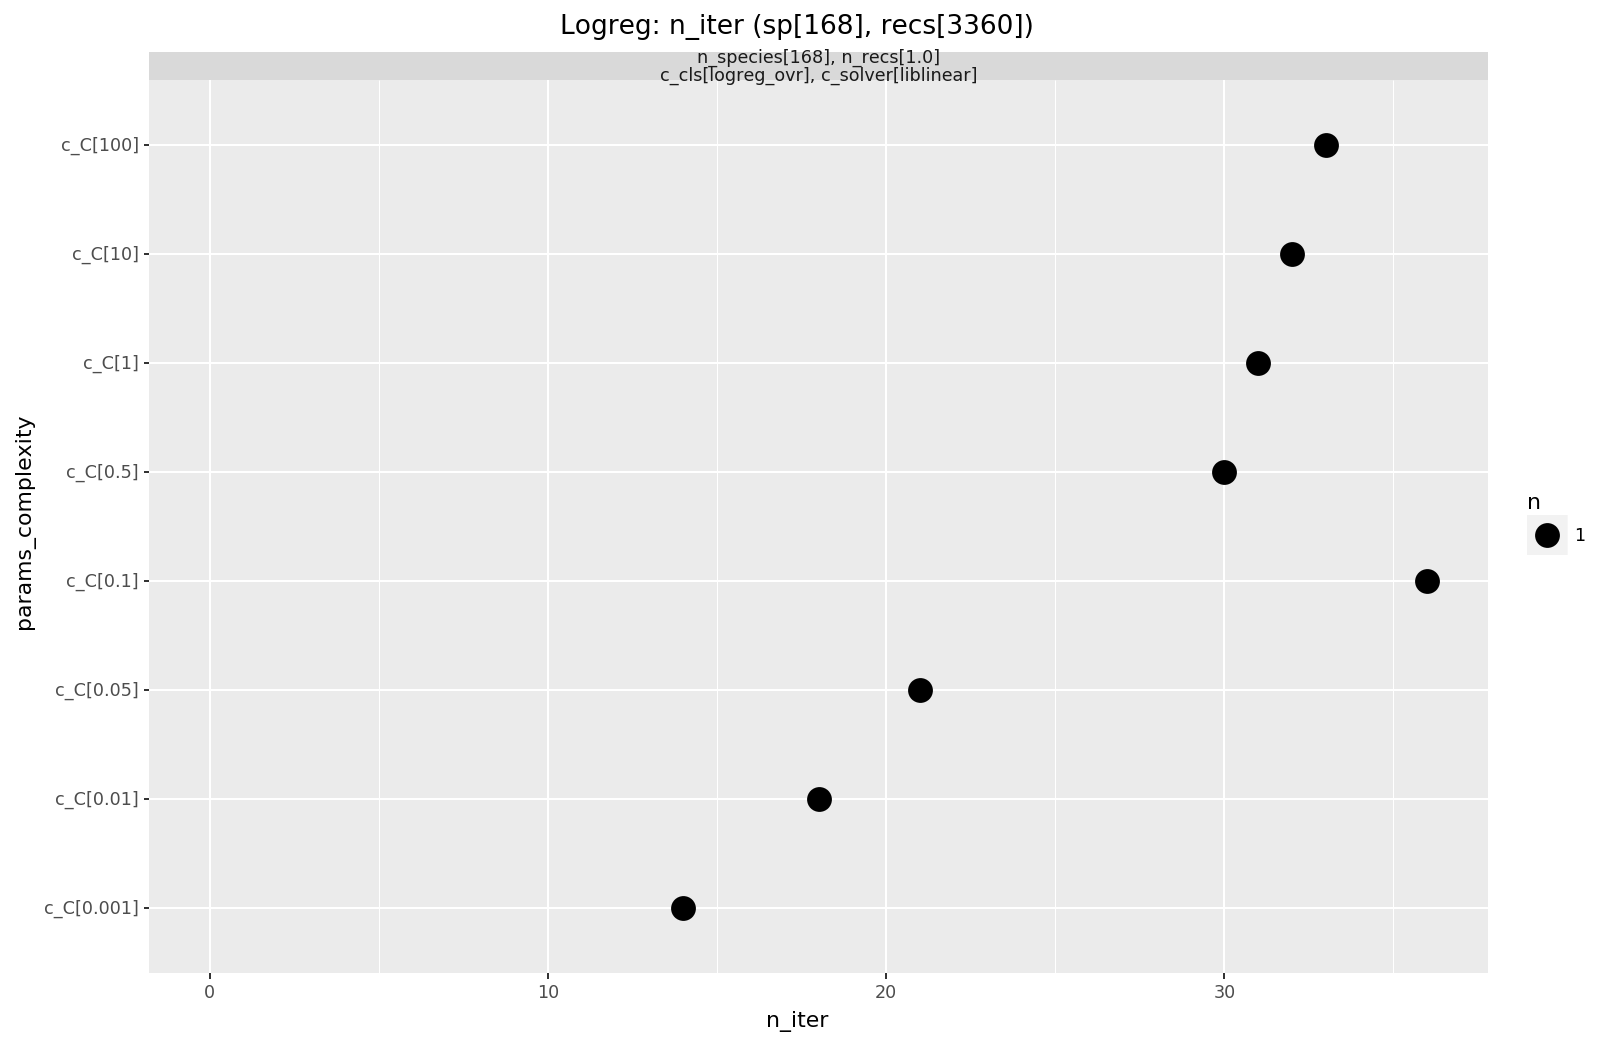

<ggplot: (-9223372036524090557)>

In [ ]:
# Tune logreg n_iter
(cv_models
    .merge(how='left', on='model_id', right=df_flatmap(cv_models, lambda row: (
        dict(model_id=row.model_id, n_iter=n_iter)
        for n_iter in coalesce(row.logreg_n_iter, [0])
    )))
    # Manually compute y.mean() per group
    # .groupby('params').apply(lambda g: g.assign(cpu_time_m_mean=lambda df: df.cpu_time_m.mean()))
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='params_complexity')
    + facet
    + geom_count(aes(y='n_iter', size='..n..')) + scale_size_area()
    + expand_limits(y=0)
    + coord_flip()
    + theme_figsize(width=12*1, aspect_ratio=1/1.5)
    + ggtitle(f'Logreg: n_iter ({recs_stats})')
)

/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/plotnine/geoms/geom_path.py:81: UserWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
  warn("geom_path: Each group consist of only one "


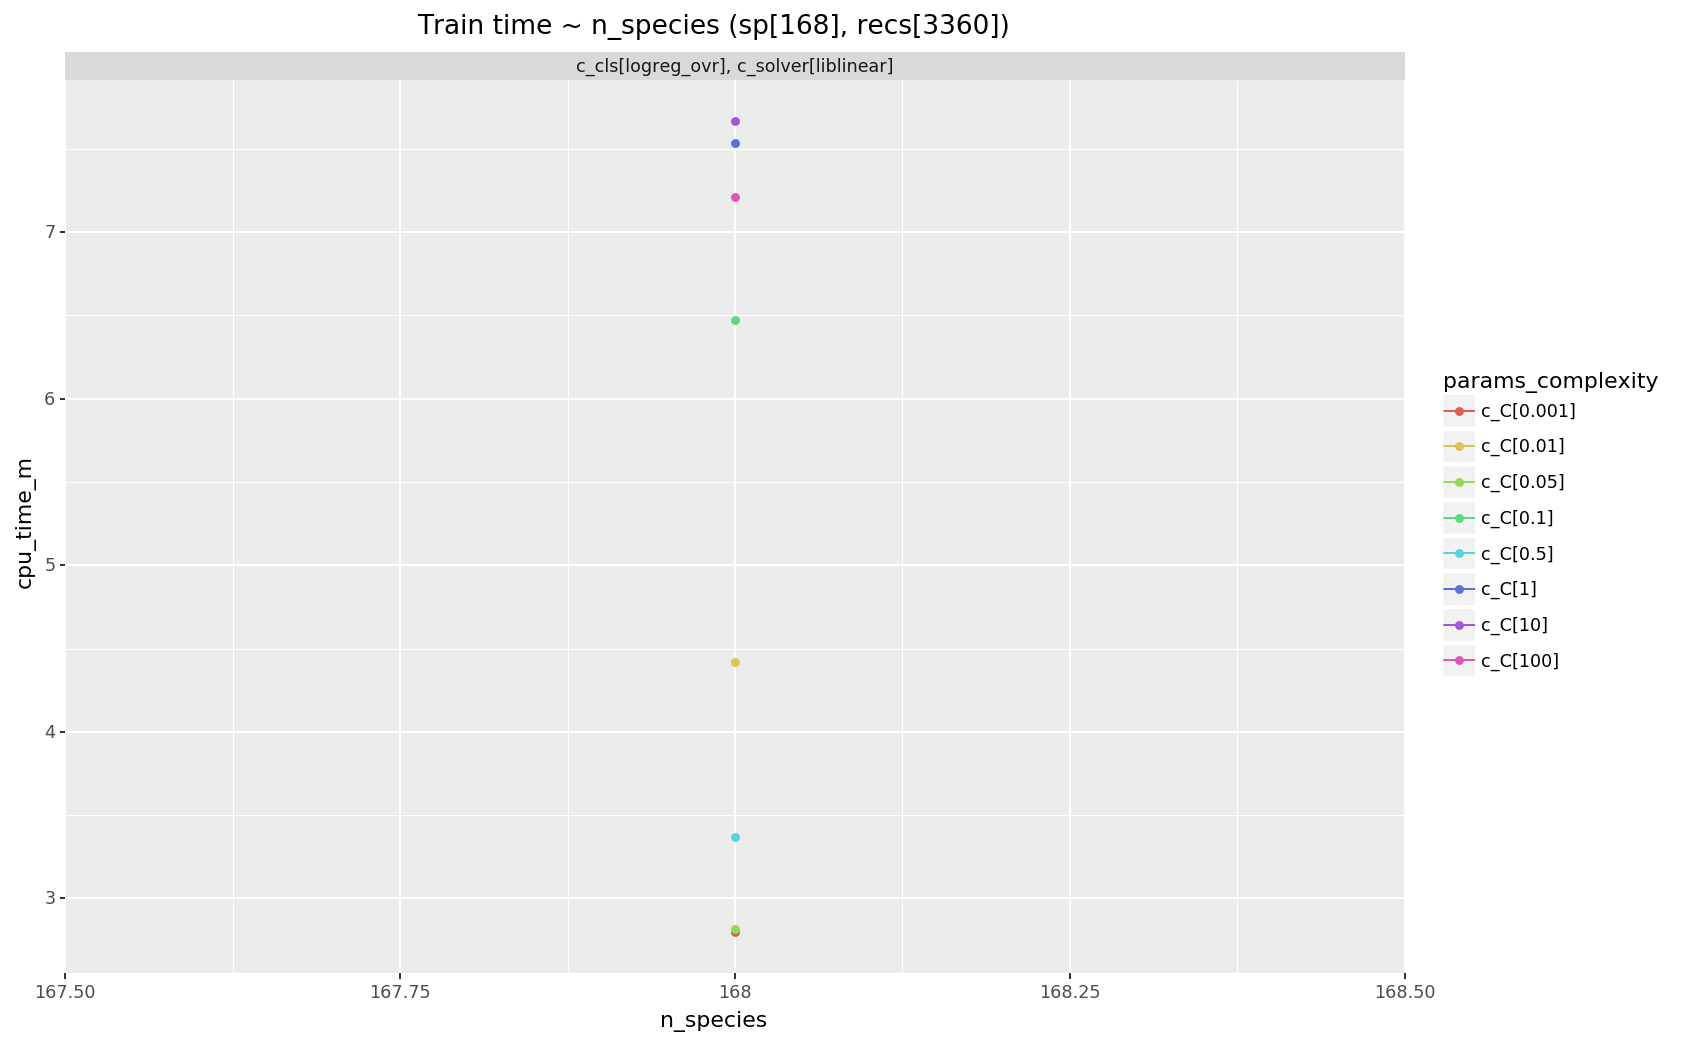

<ggplot: (-9223372036496140323)>

In [ ]:
# Train time ~ n_species
(cv_models
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='n_species', y='cpu_time_m', color='params_complexity')
    + facet_wrap('params_model', nrow=1)
    + geom_point()
    + geom_line()
    + theme_figsize(width=12*1, aspect_ratio=1/1.5)
    + ggtitle(f'Train time ~ n_species ({recs_stats})')
)

/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/plotnine/geoms/geom_path.py:81: UserWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
  warn("geom_path: Each group consist of only one "


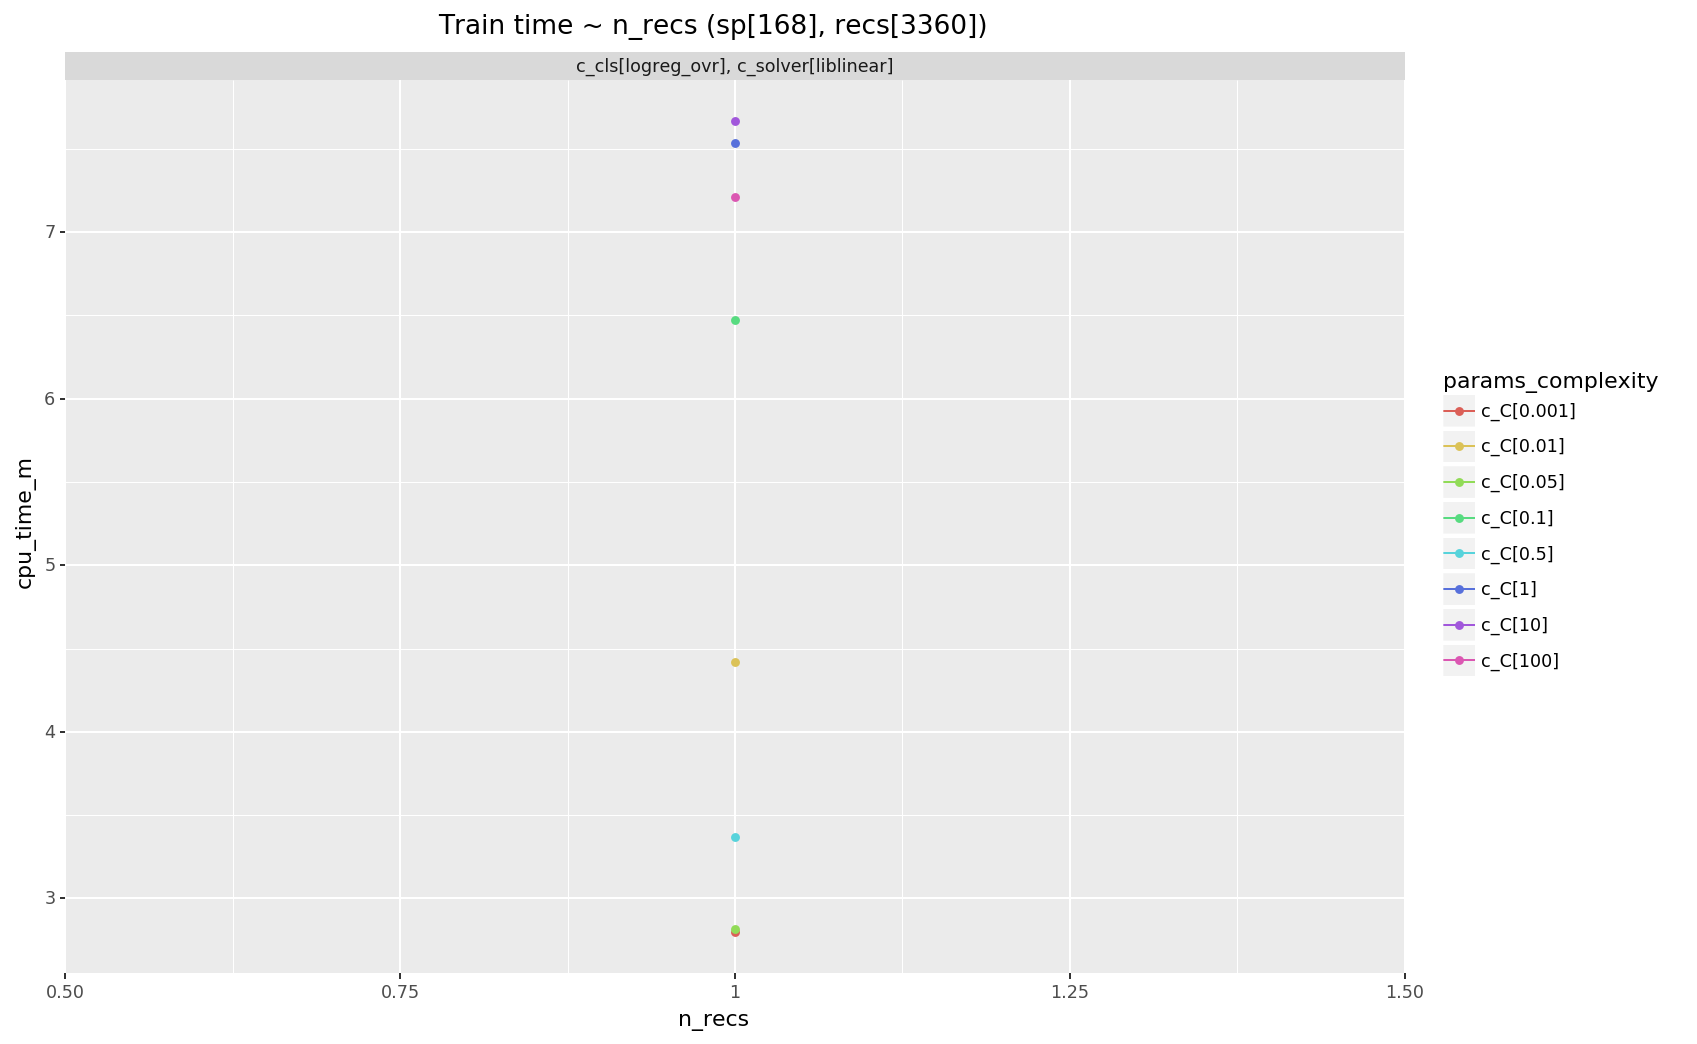

<ggplot: (-9223372036526274812)>

In [ ]:
# Train time ~ n_recs
(cv_models
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='n_recs', y='cpu_time_m', color='params_complexity')
    + facet_wrap('params_model', nrow=1)
    + geom_point()
    + geom_line()
    + theme_figsize(width=12*1, aspect_ratio=1/1.5)
    + ggtitle(f'Train time ~ n_recs ({recs_stats})')
)

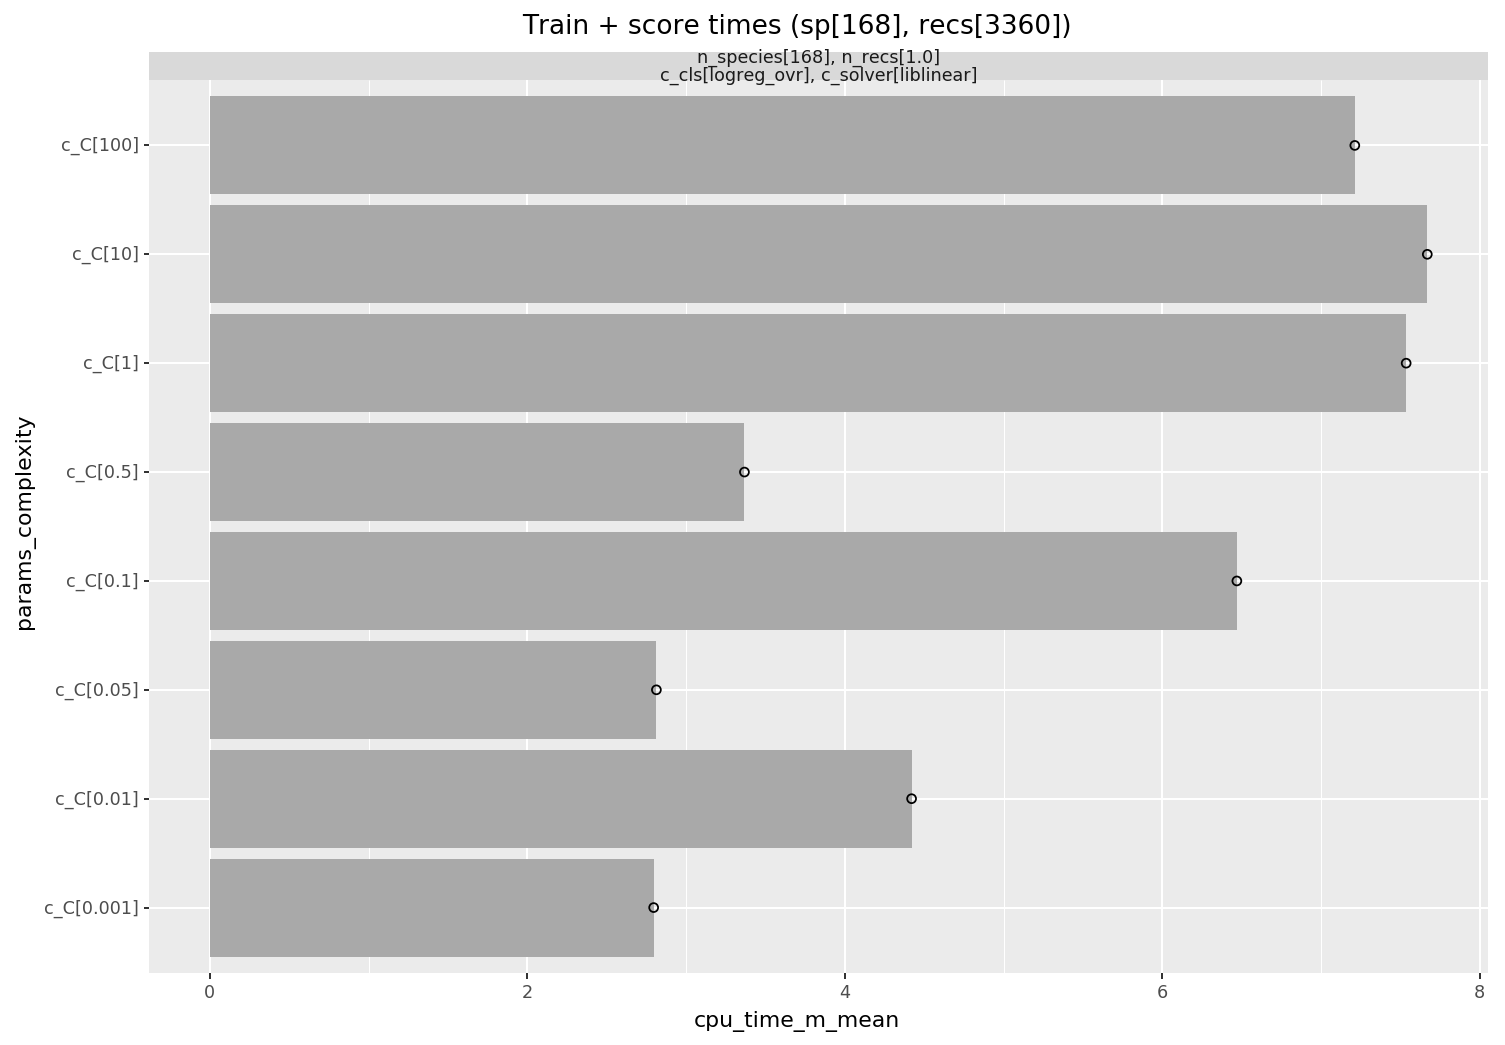

<ggplot: (328498885)>

In [ ]:
(cv_models
    # Manually compute y.mean() per group
    .groupby('params').apply(lambda g: g.assign(cpu_time_m_mean=lambda df: df.cpu_time_m.mean()))
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='params_complexity')
    + facet
    + geom_col(aes(y='cpu_time_m_mean'), fill='darkgray', position=position_dodge())
    + geom_point(aes(y='cpu_time_m'), color='black', fill='none', size=2)
    + coord_flip()
    + theme_figsize(width=12*1, aspect_ratio=1/1.5)
    + ggtitle(f'Train + score times ({recs_stats})')
)

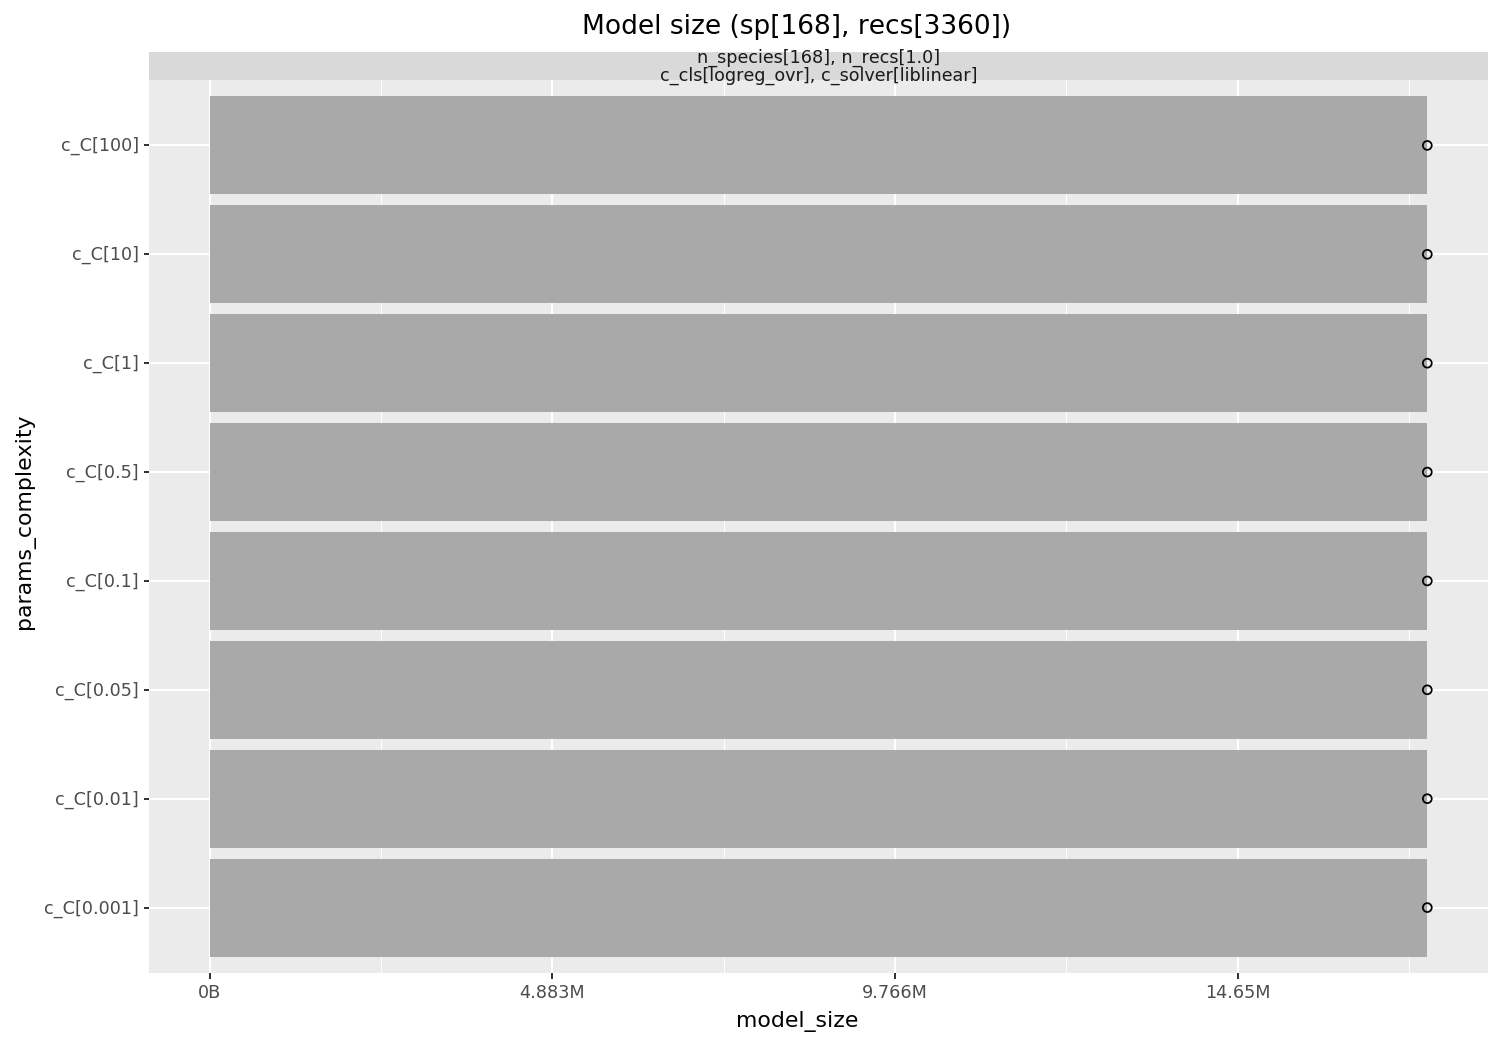

<ggplot: (-9223372036523447520)>

In [ ]:
(cv_models
    # Manually compute y.mean() per group
    .groupby('params').apply(lambda g: g.assign(model_size_mean=lambda df: df.model_size.mean()))
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='params_complexity')
    + facet
    + geom_col(aes(y='model_size_mean'), fill='darkgray', position=position_dodge()) # Summary per fold
    + geom_point(aes(y='model_size'), color='black', fill='none', size=2) # Distribution of folds
    + scale_y_continuous(labels=labels_bytes(), breaks=breaks_bytes())
    + coord_flip()
    + ylab('model_size')
    + theme_figsize(width=12*1, aspect_ratio=1/1.5)
    + ggtitle(f'Model size ({recs_stats})')
)

In [ ]:
# TODO Make not barf on non-tree models (blocks rest of notebook)
(cv_models
    # Manually compute boxplot stats, else it's _really_ slow (or you have to downsample, which misses outliers)
    #   - Based on stat_boxplot.compute_group
    .merge(how='left', on='params', right=cv_models.groupby('params').apply(lambda g: one(
        pd.Series(dict(
            params=g.name,
            ymin=boxplot['whislo'],
            lower=boxplot['q1'],
            middle=boxplot['med'],
            upper=boxplot['q3'],
            ymax=boxplot['whishi'],
            outliers=np.unique(boxplot['fliers']),  # np.unique else really slow, because lots of repeated (int) points
        ))
        for [boxplot] in [mpl.cbook.boxplot_stats(  # [boxplot] is 1 elem because X.ndim = 1
            X=np.concatenate([[] if x is None else x.depth for x in g.model_stats]),
            whis=1.5,
        )]
    )))
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='params_complexity')
    + facet
    + geom_boxplot(
        stat='identity',
        outlier_size=.5,
        mapping=aes(ymin='ymin', ymax='ymax', upper='upper', lower='lower', middle='middle', outliers='outliers',
            width=.8,  # Close enough to geom_boxplot defaults [TODO Maybe should compute based on num categorical x's?]
        ),
    )
    + ylab('tree_depth')
    + coord_flip()
    + theme_figsize(width=12*2, aspect_ratio=1/1.5)
    + ggtitle(f'Tree depth ({recs_stats})')
)

[skip]

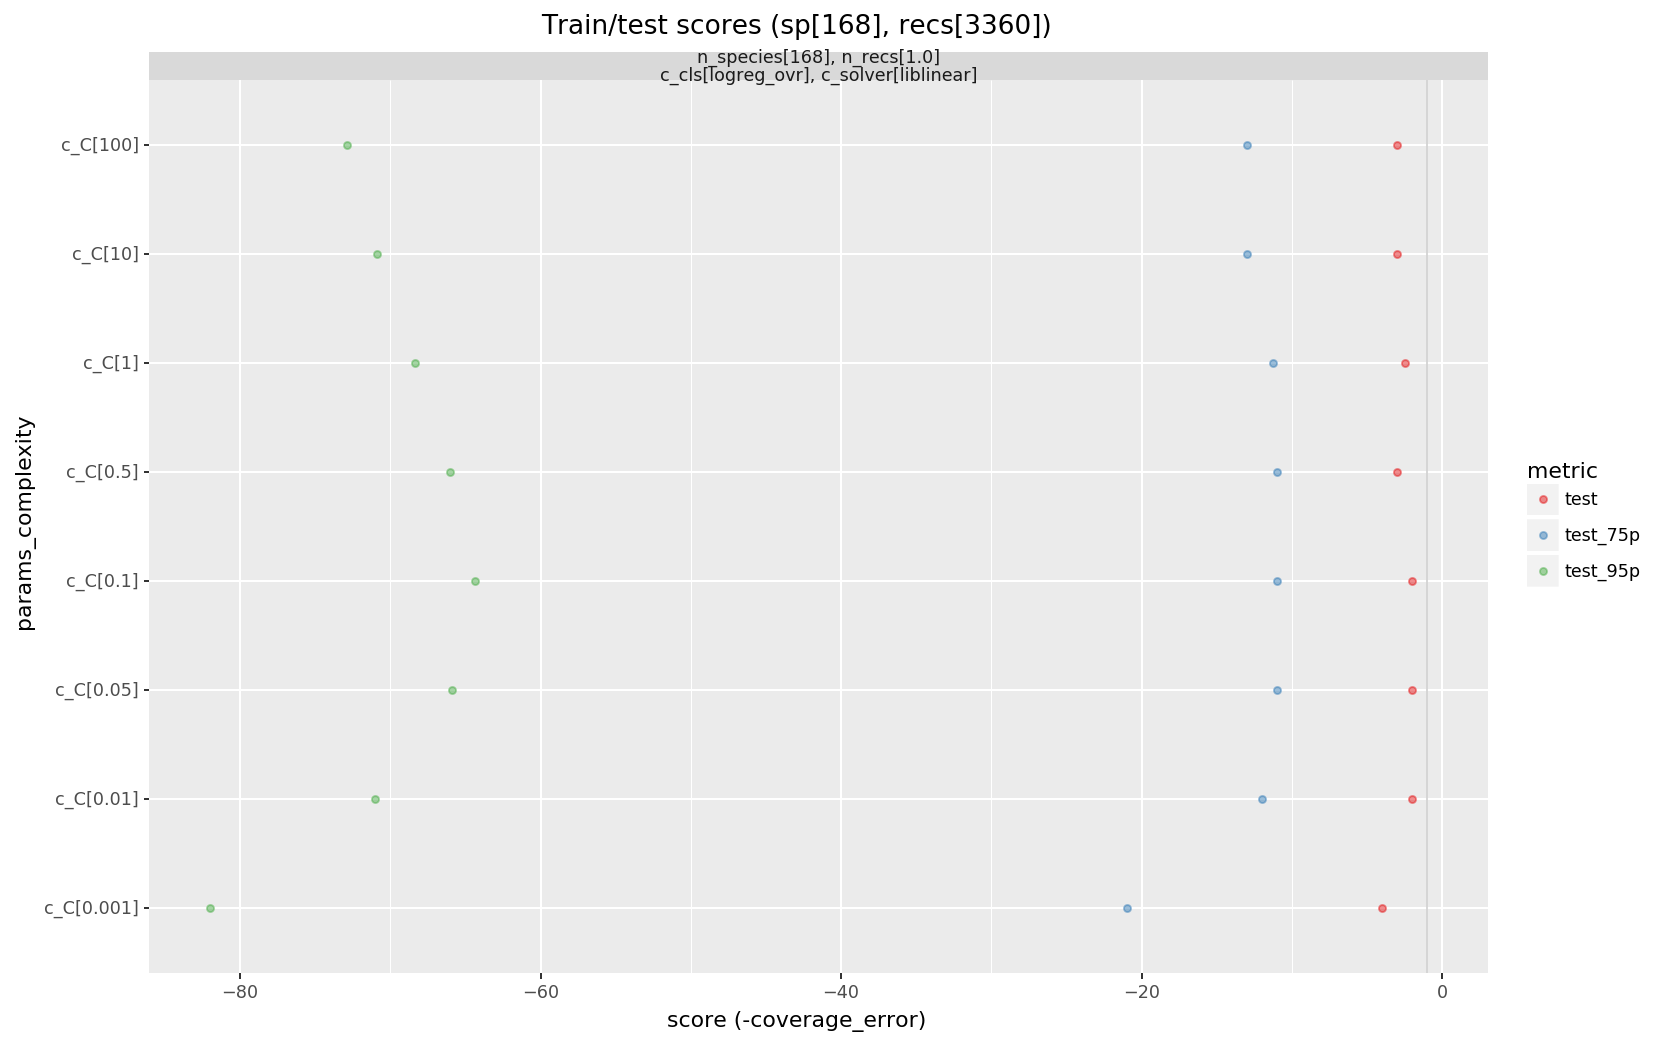

<ggplot: (326971179)>

In [ ]:
# Train/test scores
#   - Grain: models x {train,test}
#   - Metrics: score
#   - Dims: group, params
(cv_models
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(lambda df: pd.melt(df,
        id_vars=[
            'params', 'params_data', 'params_model', 'params_complexity',
            'params_data_and_model', 'params_model_and_complexity',
            'n_species', 'n_recs',
            'fold',
        ],
        value_vars=[
            # 'train_score',  # Boring
            'test_score',
            'test_75p_score',
            'test_95p_score',
        ],
        var_name='metric',
        value_name='score'),
    )
    .assign(
        metric=lambda df: df.metric.str.replace('_score', ''),
        group=lambda df: df.params_complexity.str.cat(df.metric, '/'),
    )
    .pipe(df_ordered_cat,
        group=lambda df: reversed(df.group.unique()),
    )
    .pipe(ggplot)
    + aes(x='params_complexity')
    + aes(y='score')
    + aes(color='metric')
    # + facet_grid('params_data ~ params_model')
    + facet
    + geom_hline(yintercept=-1, color='lightgrey')  # -1 is the max score (1 is the min coverage_error)
    + geom_point(alpha=.5)
    # + geom_jitter(fill='none', size=3, height=1e-9, width=.05)
    # + geom_count(aes(size='..n..')) + scale_size_area()
    # + stat_summary(aes(group='group'), fun_data='mean_cl_boot', random_state=0, geom='errorbar')
    + coord_flip(
        # ylim=(-40, 0),
    )
    # + scale_color_cmap_d('tab10')
    + scale_color_cmap_d('Set1')
    + theme_figsize(width=12*1, aspect_ratio=1/1.5)
    + ylab('score (-coverage_error)')
    + ggtitle(f'Train/test scores ({recs_stats})')
)

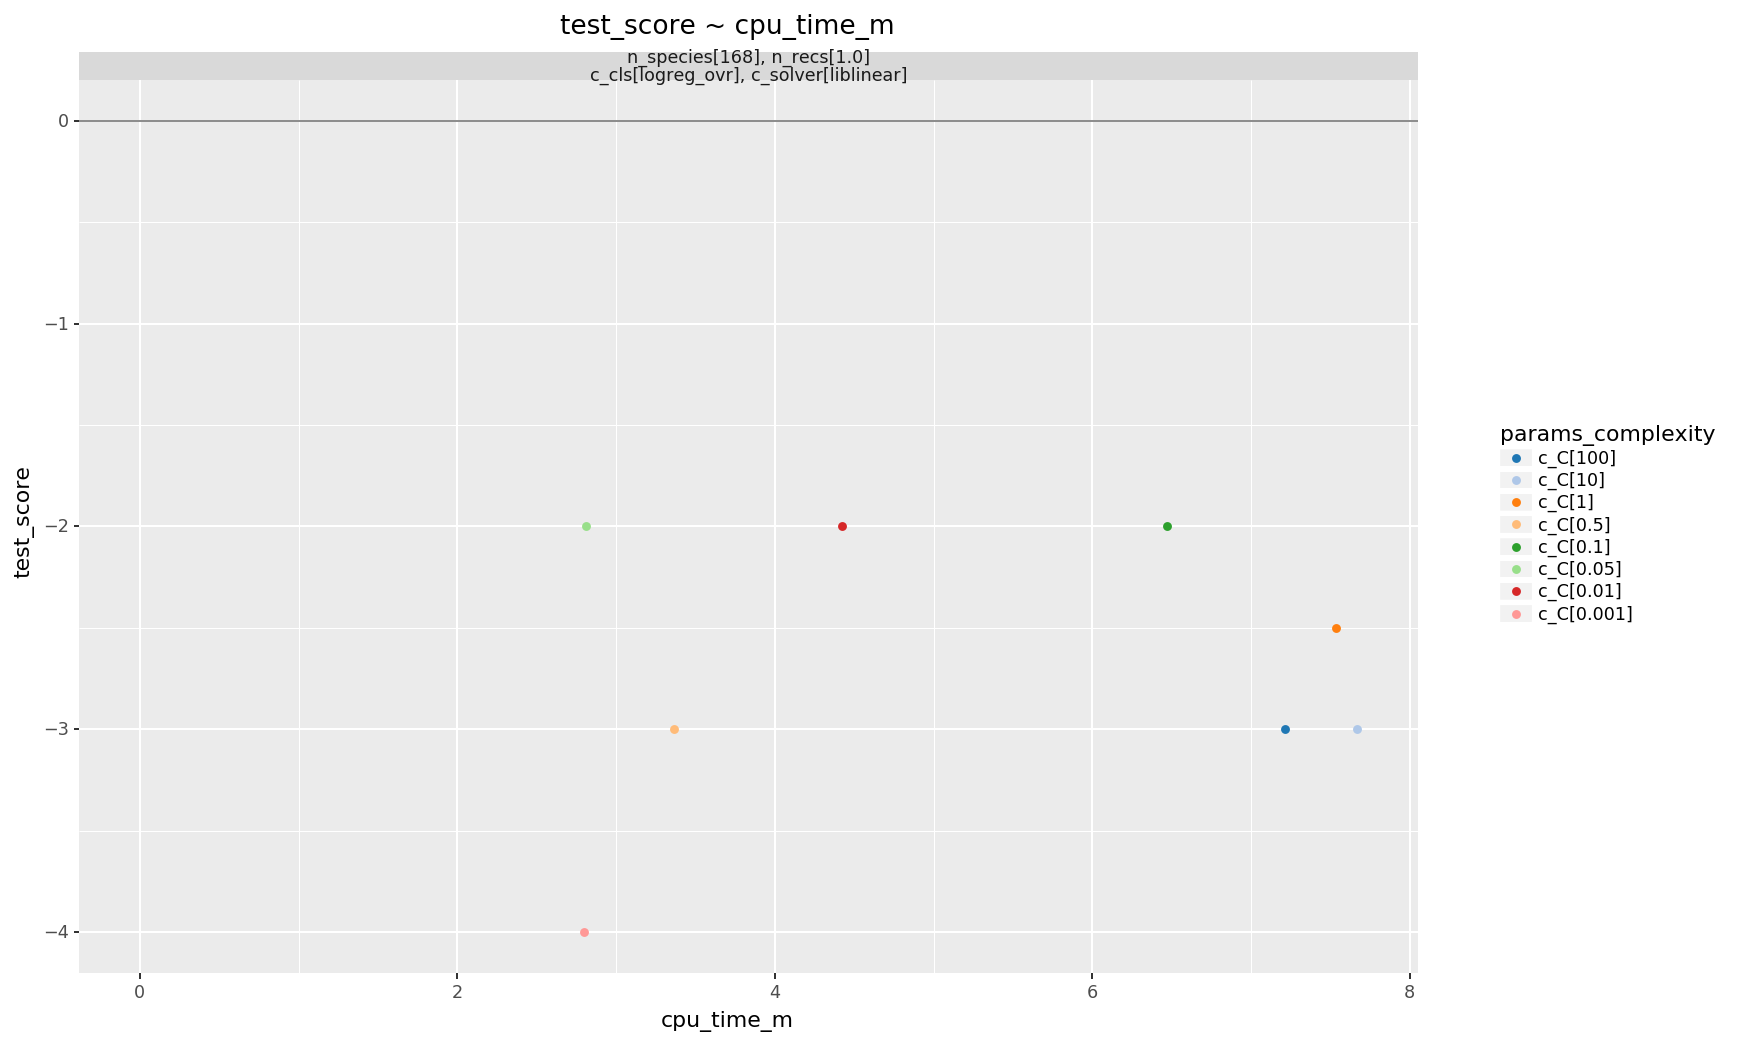

<ggplot: (329216979)>

In [ ]:
(cv_models
    .pipe(ggplot)
    + aes(x='cpu_time_m', y='test_score')
    + aes(color='params_complexity')
    + facet
    + geom_point()
    + geom_hline(yintercept=0, color='grey')
    + expand_limits(x=0)
    # + ylim(-30, 0)
    + scale_color_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + guides(color=guide_legend(ncol=1)) + theme(legend_position='right', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize(width=12*1, aspect_ratio=1/1.5)
    + ggtitle('test_score ~ cpu_time_m')
)

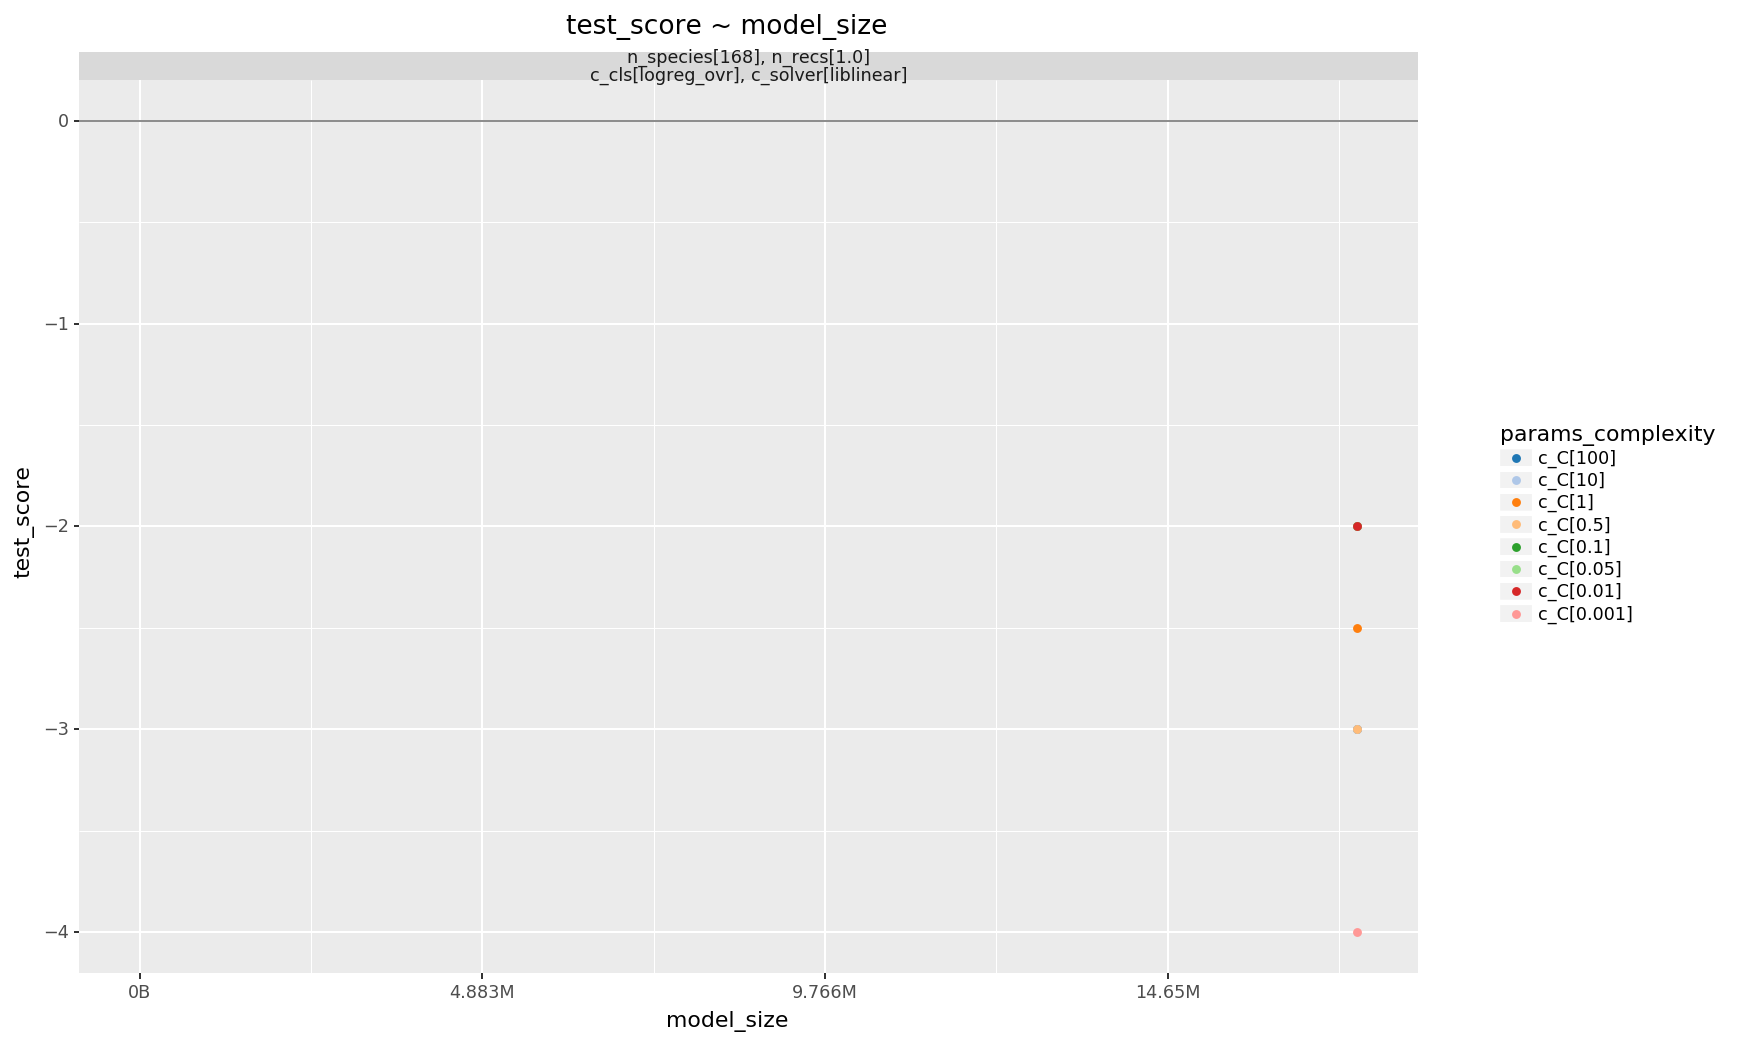

<ggplot: (330682944)>

In [ ]:
(cv_models
    .pipe(ggplot)
    + aes(x='model_size', y='test_score')
    + aes(color='params_complexity')
    + facet
    + geom_point()
    + geom_hline(yintercept=0, color='grey')
    + scale_x_continuous(labels=labels_bytes(), breaks=breaks_bytes())
    + expand_limits(x=0)
    # + ylim(-30, 0)
    + scale_color_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + guides(color=guide_legend(ncol=1)) + theme(legend_position='right', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize(width=12*1, aspect_ratio=1/1.5)
    + ggtitle('test_score ~ model_size')
)

In [ ]:
SLOW_PLOTS_NEXT

NameError: name 'SLOW_PLOTS_NEXT' is not defined

# Model diagnostics: all models, all folds

In [ ]:
print('models:')
print('  params[*/%s]' % len(cv_models.params.cat.categories))
print('  fold[*/%s]' % cv.cv.n_splits)

models:
  params[*/8]
  fold[*/1]


In [ ]:
# TODO Cache
# Coverage errors: all models, all folds
#   - Subset: all models
#   - Grain: sum(recs[model.test_i] for model)
#   - Dims: model_id, params, fold, y_true, rec_id
#   - Metrics: coverage_error
coverage_errors_all_all = (cv_models
    # .sample(n=5, random_state=0)  # For faster dev
    .pipe(lambda df: DF(
        OrderedDict(
            # **row[['model_id', 'params', 'fold']],  # Slow (in this inner loop), unpack manually instead
            model_id=row.model_id,
            params=row.params,
            params_data=row.params_data,
            params_model=row.params_model,
            params_complexity=row.params_complexity,
            params_data_and_model=row.params_data_and_model,
            params_model_and_complexity=row.params_model_and_complexity,
            fold=row.fold,
            i=i,
            y_true=y_true,
            coverage_error=coverage_error,
        )
        for row in iter_progress(df_rows(df), n=len(df))
        for i, y_true, coverage_error in zip(
            row.test_evals.i,
            row.test_evals.y,
            row.test_evals.coverage_errors(),
        )
    ))
    .astype(dict(
        model_id=cv_models.model_id.dtype,
        params=cv_models.params.dtype,
        params_data=cv_models.params_data.dtype,
        params_model=cv_models.params_model.dtype,
        params_complexity=cv_models.params_complexity.dtype,
        params_data_and_model=cv_models.params_data_and_model.dtype,
        params_model_and_complexity=cv_models.params_model_and_complexity.dtype,
    ))
    .pipe(tap, lambda df: display(
        df_summary(df).T,
        df[:10],
    ))
)

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

 25%|█████████████████████                                                               | 2/8 [00:00<00:00, 15.72it/s]

 50%|██████████████████████████████████████████                                          | 4/8 [00:00<00:00, 15.94it/s]

 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:00<00:00, 16.07it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 15.99it/s]

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
model_id,category,715680,5376,5376,8,NaN,NaN,"n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.001], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.1], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[1], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[100], fold[0]"
params,category,667296,5376,5376,8,NaN,NaN,"n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.001]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.1]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[1]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[100]"
params_data,category,408576,5376,5376,1,NaN,NaN,"n_species[168], n_recs[1.0]","n_species[168], n_recs[1.0]","n_species[168], n_recs[1.0]","n_species[168], n_recs[1.0]","n_species[168], n_recs[1.0]"
params_model,category,1306368,5376,5376,1,NaN,NaN,"c_cls[logreg_ovr], c_solver[liblinear]","c_cls[logreg_ovr], c_solver[liblinear]","c_cls[logreg_ovr], c_solver[liblinear]","c_cls[logreg_ovr], c_solver[liblinear]","c_cls[logreg_ovr], c_solver[liblinear]"
params_complexity,category,503328,5376,5376,8,NaN,NaN,c_C[100],c_C[10],c_C[0.5],c_C[0.05],c_C[0.001]
params_data_and_model,category,618240,5376,5376,1,NaN,NaN,"n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear]","n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear]","n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear]","n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear]","n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear]"
params_model_and_complexity,category,516768,5376,5376,8,NaN,NaN,"c_cls[logreg_ovr], c_solver[liblinear]\nc_C[100]","c_cls[logreg_ovr], c_solver[liblinear]\nc_C[10]","c_cls[logreg_ovr], c_solver[liblinear]\nc_C[0.5]","c_cls[logreg_ovr], c_solver[liblinear]\nc_C[0.05]","c_cls[logreg_ovr], c_solver[liblinear]\nc_C[0.001]"
fold,int64,129024,5376,5376,1,0.000,0.000,0,0,0,0,0
i,int64,150496,5376,5376,672,1679.338,970.151,0,837,1677,2517,3348


,model_id,params,params_data,params_model,params_complexity,params_data_and_model,params_model_and_complexity,fold,i,y_true,coverage_error
0,"n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.001], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.001]","n_species[168], n_recs[1.0]","c_cls[logreg_ovr], c_solver[liblinear]",c_C[0.001],"n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear]","c_cls[logreg_ovr], c_solver[liblinear]\nc_C[0.001]",0,1765,CASJ,10.0
1,"n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.001], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.001]","n_species[168], n_recs[1.0]","c_cls[logreg_ovr], c_solver[liblinear]",c_C[0.001],"n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear]","c_cls[logreg_ovr], c_solver[liblinear]\nc_C[0.001]",0,1551,VEFL,1.0
2,"n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.001], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.001]","n_species[168], n_recs[1.0]","c_cls[logreg_ovr], c_solver[liblinear]",c_C[0.001],"n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear]","c_cls[logreg_ovr], c_solver[liblinear]\nc_C[0.001]",0,2967,LISP,19.0
3,"n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.001], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.001]","n_species[168], n_recs[1.0]","c_cls[logreg_ovr], c_solver[liblinear]",c_C[0.001],"n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear]","c_cls[logreg_ovr], c_solver[liblinear]\nc_C[0.001]",0,578,LBCU,4.0
4,"n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.001], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.001]","n_species[168], n_recs[1.0]","c_cls[logreg_ovr], c_solver[liblinear]",c_C[0.001],"n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear]","c_cls[logreg_ovr], c_solver[liblinear]\nc_C[0.001]",0,684,BOGU,17.0
5,"n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.001], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.001]","n_species[168], n_recs[1.0]","c_cls[logreg_ovr], c_solver[liblinear]",c_C[0.001],"n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear]","c_cls[logreg_ovr], c_solver[liblinear]\nc_C[0.001]",0,1209,BTAH,1.0
6,"n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.001], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.001]","n_species[168], n_recs[1.0]","c_cls[logreg_ovr], c_solver[liblinear]",c_C[0.001],"n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear]","c_cls[logreg_ovr], c_solver[liblinear]\nc_C[0.001]",0,2372,BETH,1.0
7,"n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.001], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.001]","n_species[168], n_recs[1.0]","c_cls[logreg_ovr], c_solver[liblinear]",c_C[0.001],"n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear]","c_cls[logreg_ovr], c_solver[liblinear]\nc_C[0.001]",0,2874,WCSP,111.0
8,"n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.001], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.001]","n_species[168], n_recs[1.0]","c_cls[logreg_ovr], c_solver[liblinear]",c_C[0.001],"n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear]","c_cls[logreg_ovr], c_solver[liblinear]\nc_C[0.001]",0,1424,LEFL,2.0
9,"n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.001], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.001]","n_species[168], n_recs[1.0]","c_cls[logreg_ovr], c_solver[liblinear]",c_C[0.001],"n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear]","c_cls[

In [ ]:
[print(x) for x in coverage_errors_all_all.params_data.unique()];
params_data = (
    'n_species[168], n_recs[1.0]'
    # 'n_species[336], n_recs[1.0]'
    # 'n_species[159], n_recs[1.0]'
)
n_species = parse.search('n_species[{n_species:d}], n_recs[{n_recs:f}]', params_data)['n_species']

n_species[168], n_recs[1.0]


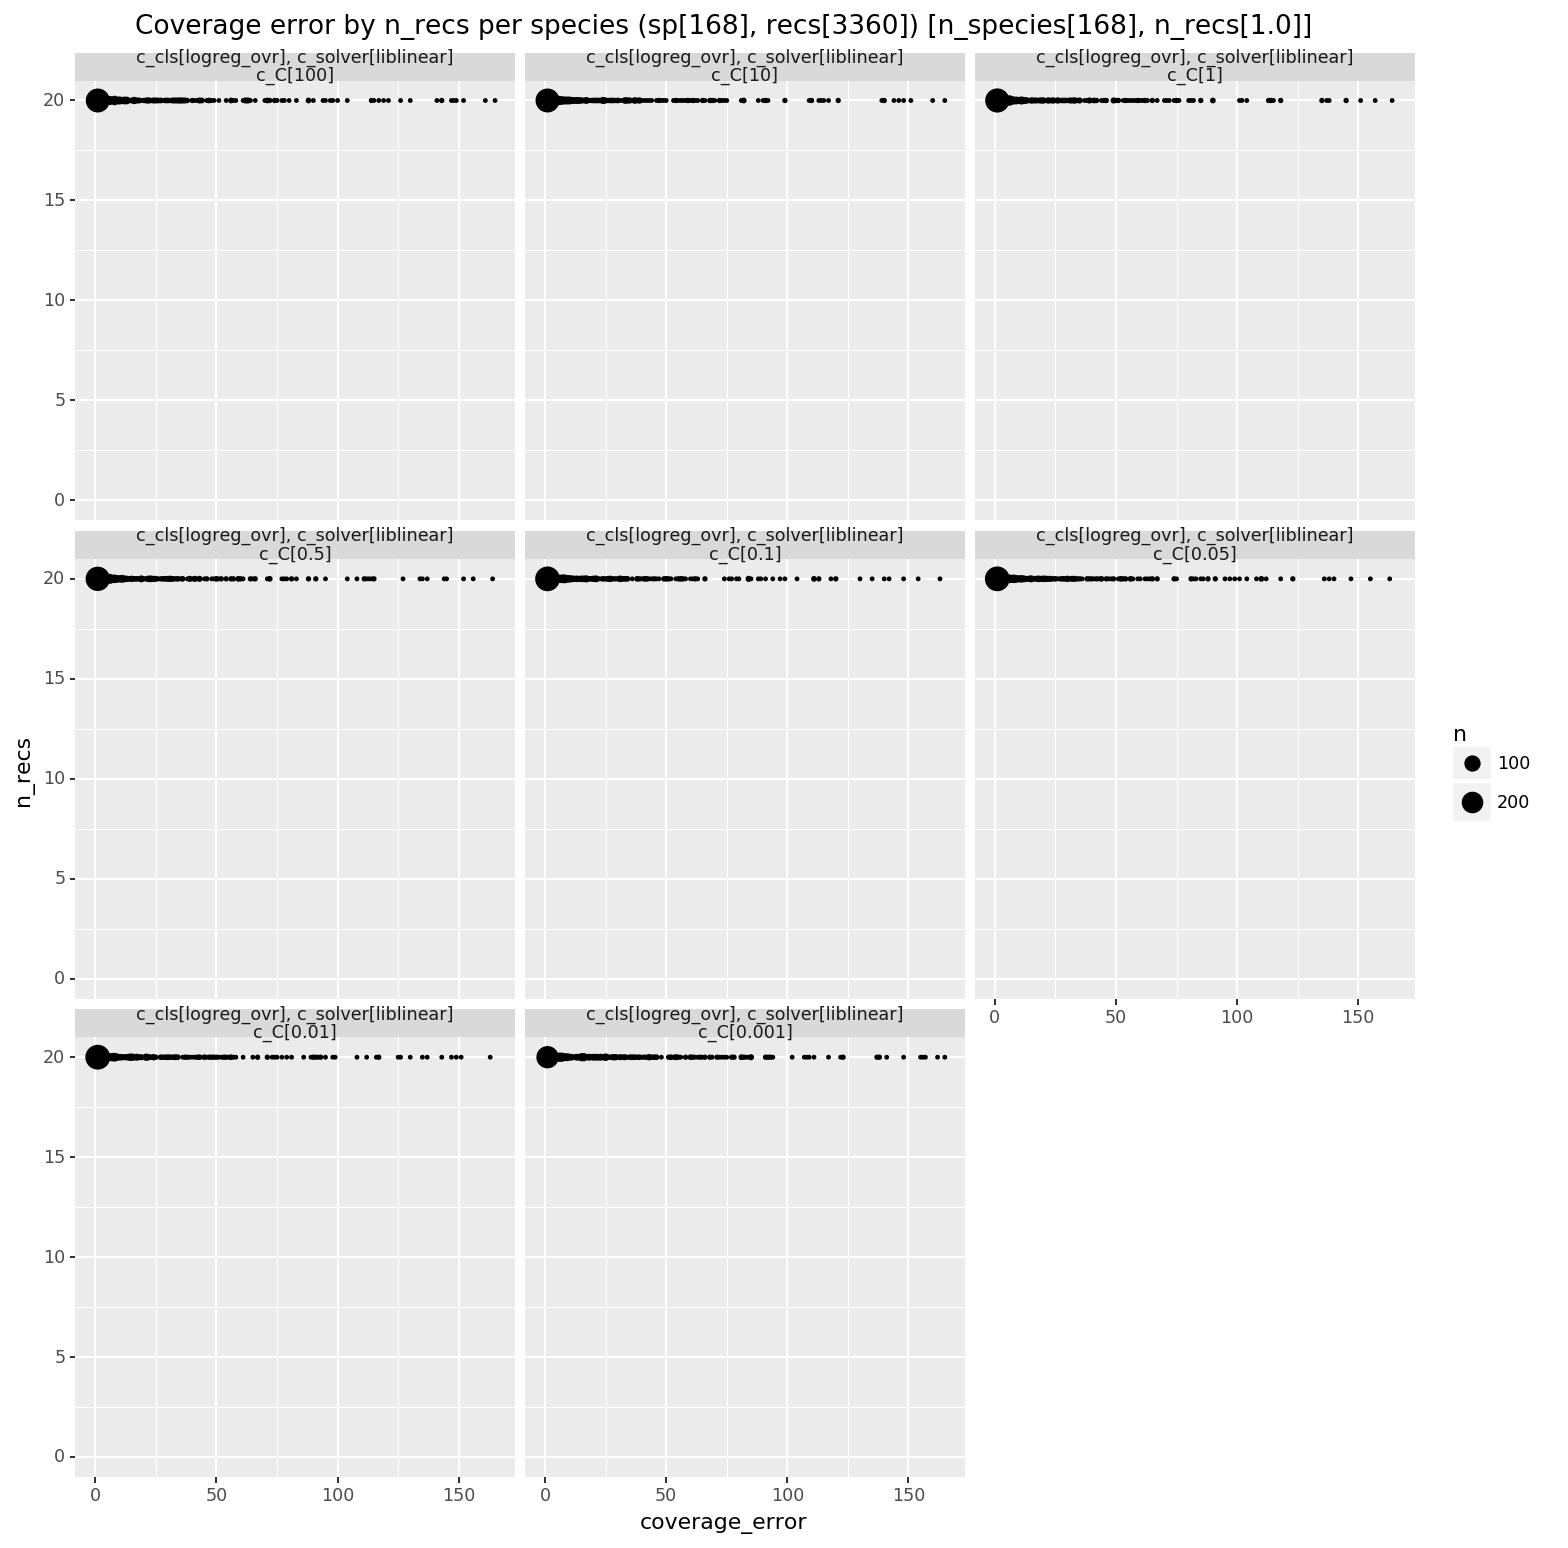

<ggplot: (-9223372036527808617)>

In [ ]:
# TODO Class imbalance
#   1. Is class imbalance causing a problem? [-> maybe]
#   2. Is class_weight solving it? [-> maybe a little bit]
#   - TODO Try again with larger class imbalance
(coverage_errors_all_all
    [lambda df: df.params_data == params_data]
    # .sample(100, random_state=0)  # Faster dev
    .merge(how='left', on='y_true', right=(recs
        .assign(n_recs=1).groupby('species')['n_recs'].sum().reset_index()
        .rename(columns={'species': 'y_true'})
    ))
    # .pipe(puts, f=lambda df: df[:3])  # XXX Debug
    .pipe(ggplot)
    # + facet_grid('params_complexity ~ params_model')
    + facet_wrap('params_model_and_complexity')
    + aes(x='n_recs', y='coverage_error')
    + geom_count(aes(size='..n..')) + scale_size_area()
    + expand_limits(x=0, y=0)
    + coord_flip()
    + theme_figsize(width=12*1, aspect_ratio=1/1)
    + ggtitle(rf'Coverage error by n_recs per species ({recs_stats}) [{params_data}]')
)

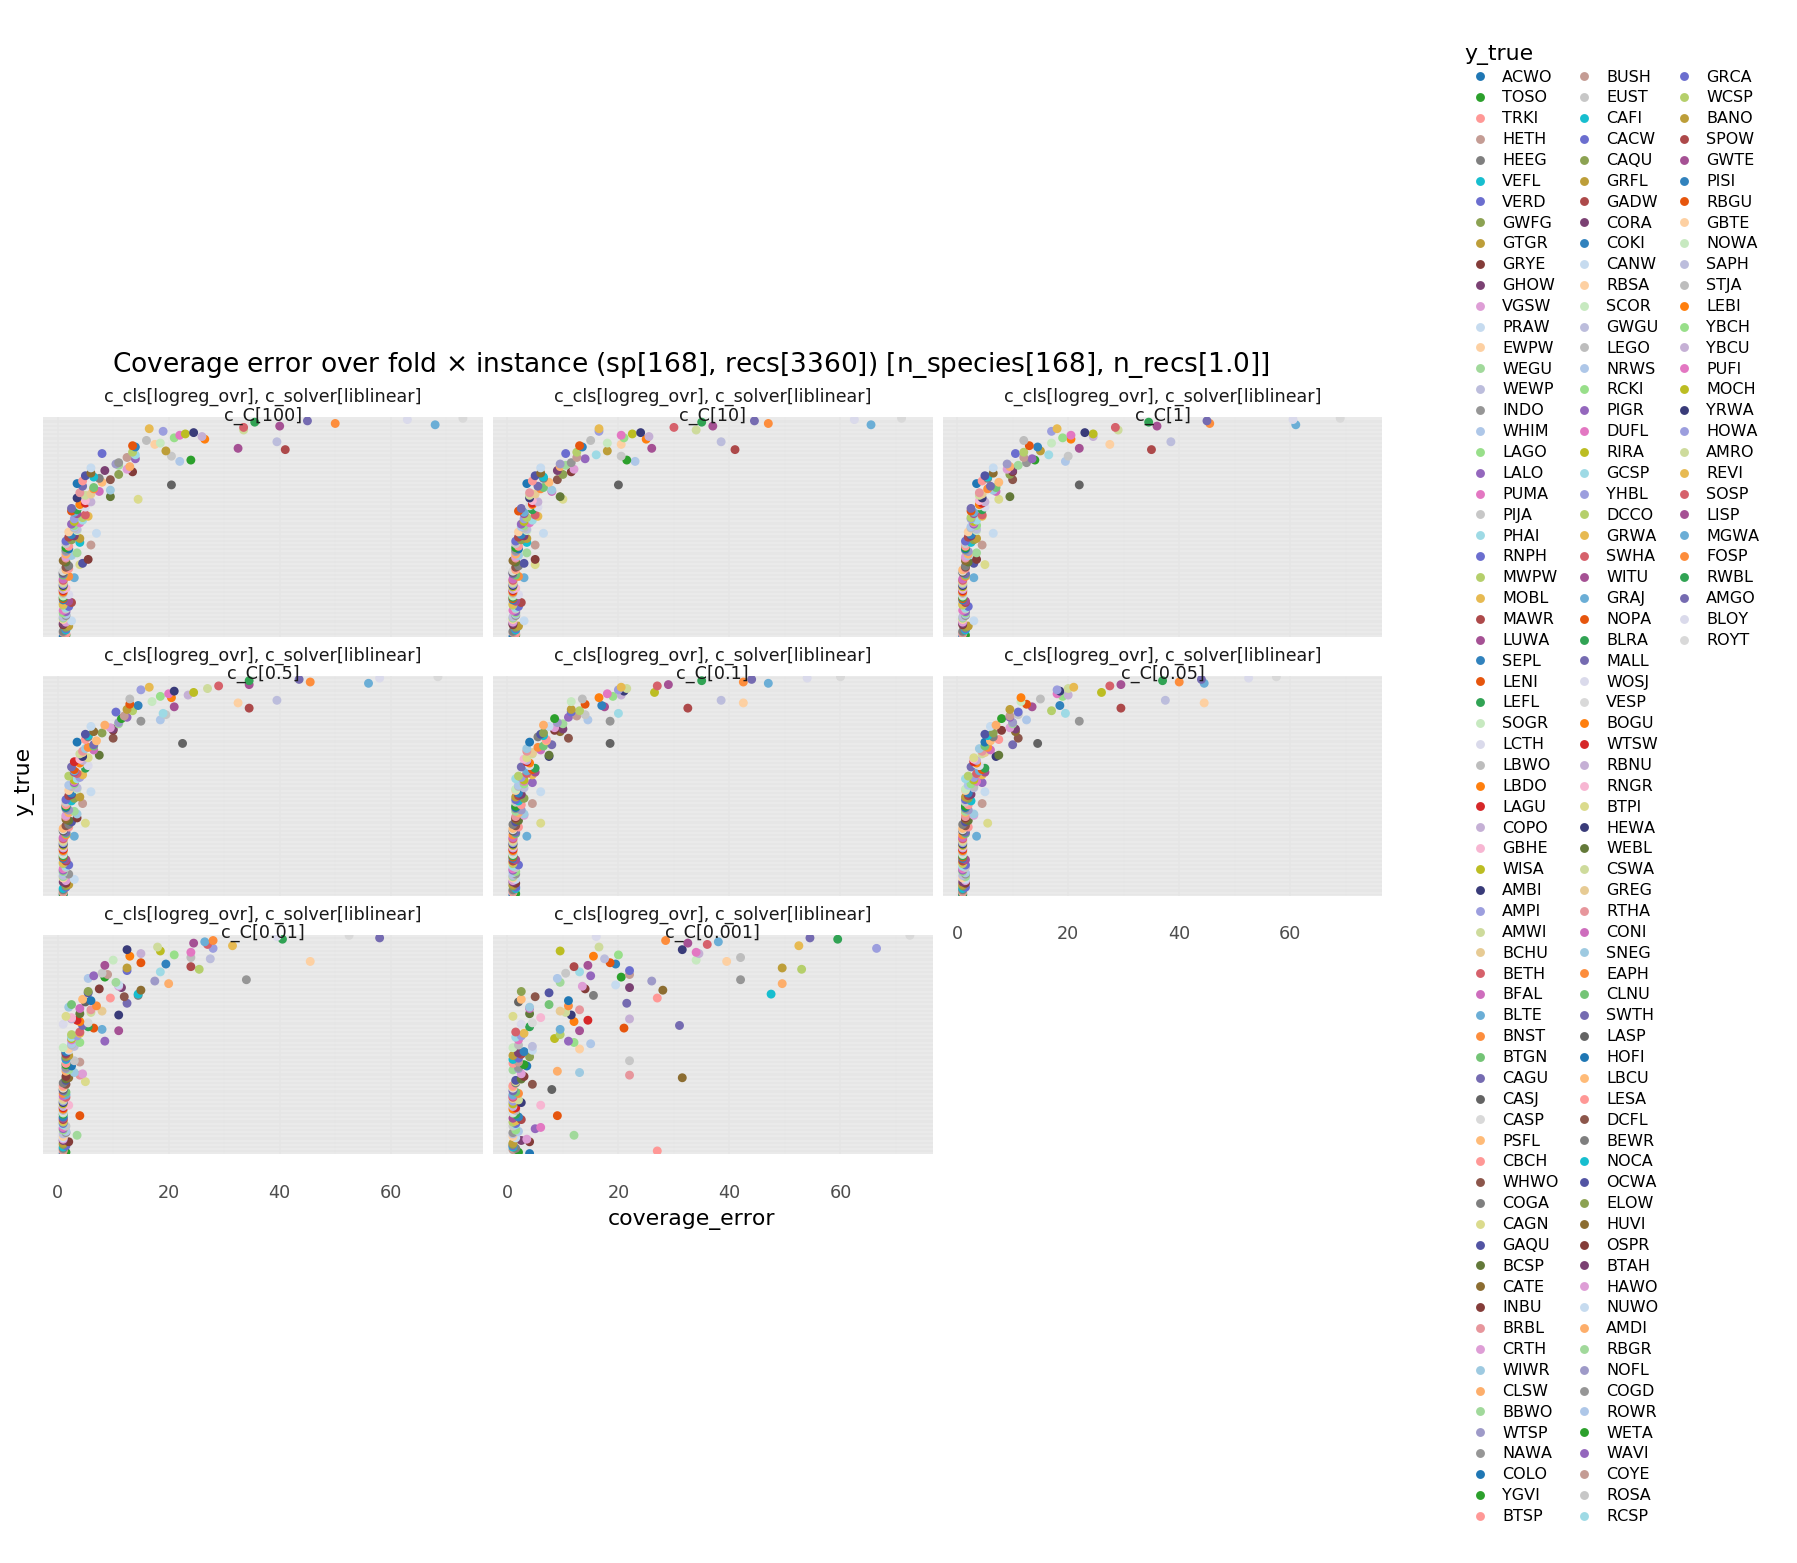

<ggplot: (-9223372036527488263)>

In [ ]:
# Facet by params_no_ns, order by median(coverage_error)
#   - Subset: all models
#   - Grain: sum(recs[model.test_i].groupby(params, y_true) for model)
#       - Over: fold, rec_id
#   - Dims: params, y_true
#   - Metrics: coverage_error.median
# in: coverage_errors_all_all, recs
(coverage_errors_all_all
    [lambda df: df.params_data == params_data]
    # .sample(100, random_state=0)  # Faster dev
    # .pipe(df_reverse_cat, 'params', 'params_no_ns', 'ns')
    .pipe(df_ordered_cat,
        y_true=lambda df: (
            # Sort species by median(coverage_error) (across all models)
            df.groupby('y_true').agg({'coverage_error': np.median}).reset_index().sort_values('coverage_error').y_true
            # Sort species by taxo (hard to compare across models, unless they're pretty low noise)
            # reversed(recs.species.cat.categories)
        ),
    )
    .pipe(ggplot)
    + aes(x='y_true', y='coverage_error')
    + aes(color='y_true')
    # + facet_grid('params_complexity ~ params_model')
    + facet_wrap('params_model_and_complexity',
        # Bug: dir='v' inverts nrow/ncol [https://github.com/has2k1/plotnine/issues/163]
        # dir='v', nrow=coverage_errors_all_all.params_model.nunique(),
    )
    # + geom_line(aes(group='params'), stat='summary', fun_y=np.median)  # TODO Bad interpolation with n_species
    + geom_point(aes(group='params'), stat='summary', fun_y=np.median)
    + coord_flip()
    # + geom_hline(yintercept=recs.species.nunique(), color='grey')
    + scale_color_cmap_d(mpl_cmap_repeat(10, 'tab20', 'tab20b', 'tab20c'))
    + theme_minimal()  # Before other theme()
    + guides(color=guide_legend(nrow=70))
    + theme(legend_position='right', legend_box_spacing=.4, legend_key_height=8, legend_text=element_text(size=8))
    + theme(axis_text_y=element_blank())
    + theme_figsize(width=12*1, aspect_ratio=1/2)
    + ggtitle(rf'Coverage error over fold $\times$ instance ({recs_stats}) [{params_data}]')
)

c_cls[logreg_ovr], c_solver[liblinear]


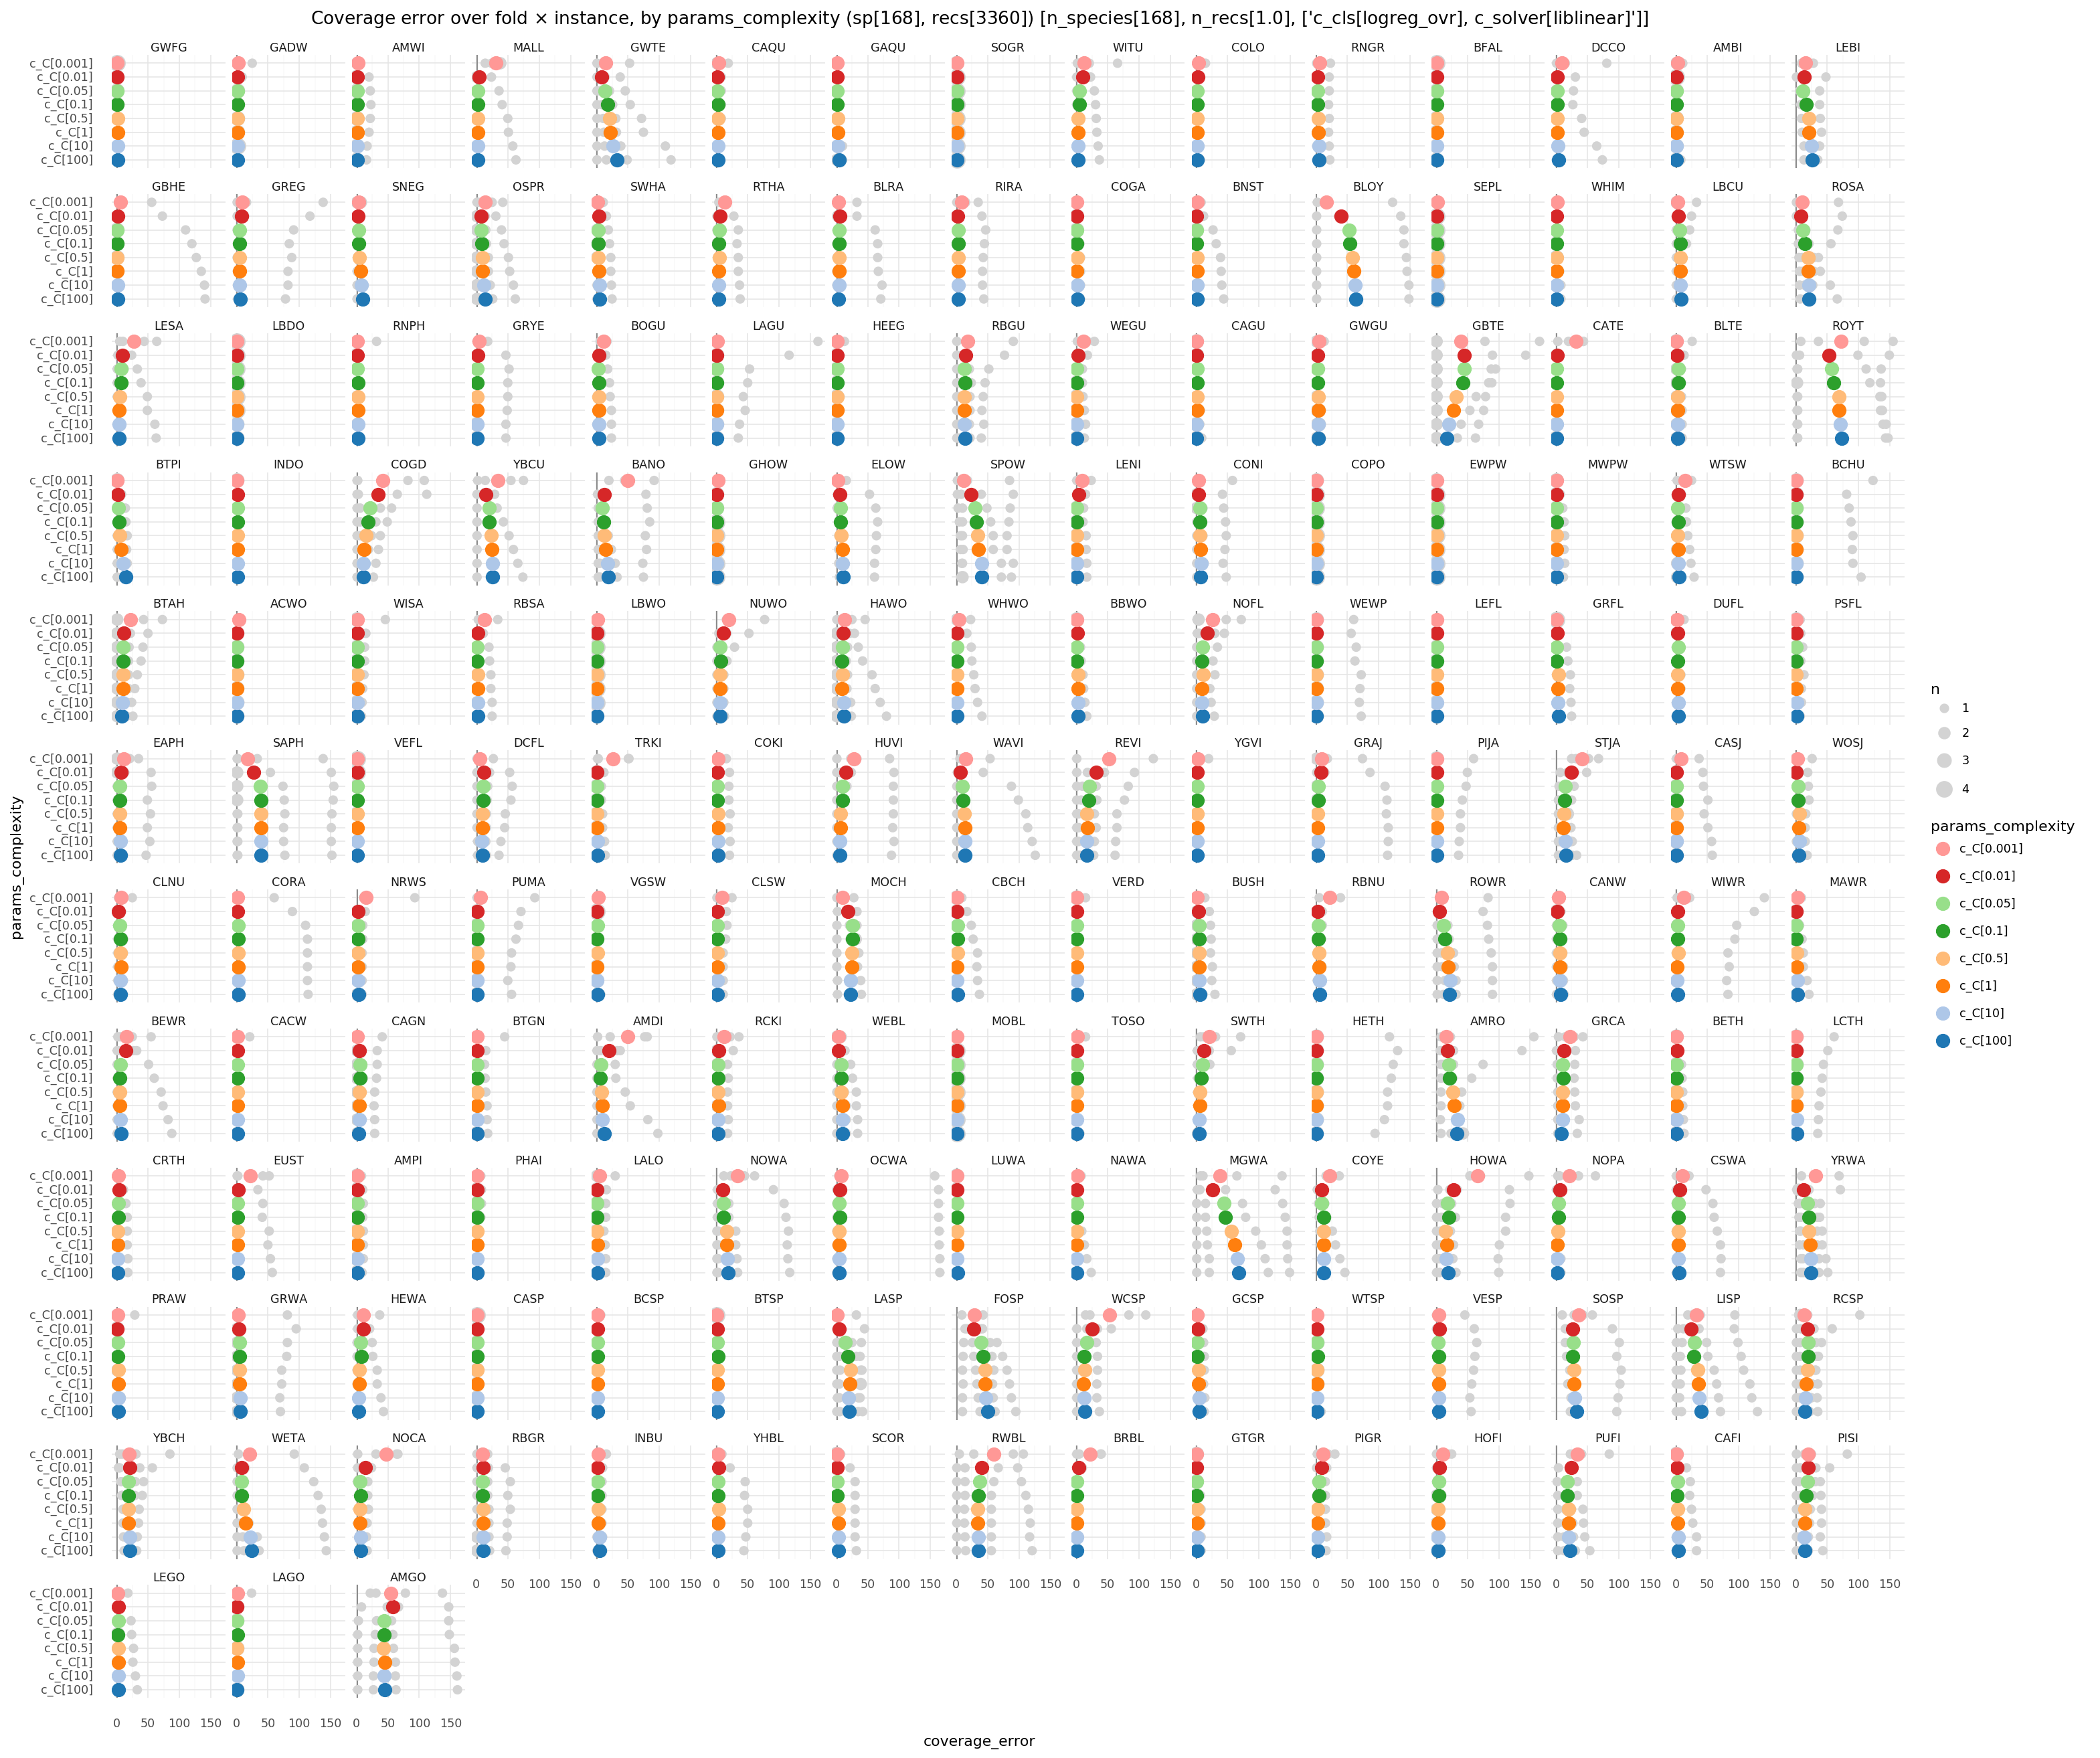

<ggplot: (-9223372036538970862)>

In [ ]:
# TODO Slow, bad for notebook dev loop -- move lower, or disable by default?
# Facet by species
#   - Subset: all models
#   - Grain: sum(recs[model.test_i].groupby(params, y_true) for model)
#       - Over: fold, rec_id
#   - Dims: params, y_true
#   - Metrics: coverage_error.median
# in: coverage_errors_all_all, recs
[print(x) for x in coverage_errors_all_all.params_model.unique()];
params_model = [
    # 'c_cls[rf], c_n_estimators[100]',
    'c_cls[logreg_ovr], c_solver[liblinear]',
    # 'c_cls[logreg_multi], c_solver[newton-cg]',
    # 'c_cls[xgb_rf], c_n_estimators[100]',
    # 'c_cls[logreg_ovr], c_solver[liblinear], c_C[0.1]',
    # 'c_cls[nb]',
]
(coverage_errors_all_all
    [lambda df: df.params_data == params_data]
    [lambda df: df.params_model.isin(params_model)]
    # .sample(200, random_state=0)  # Faster dev
    # [lambda df: df.y_true.isin(df.y_true.drop_duplicates().sample(n=3, random_state=0))]  # Faster dev
    .astype({'y_true': metadata.species.df.shorthand.dtype})
    # .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='params_complexity', y='coverage_error')
    + aes(color='params_complexity')
    + facet_wrap('y_true',
        ncol=int((n_species * 1/(2/3)) ** .5),
    )
    + geom_hline(yintercept=1, color='grey')
    # + geom_hline(yintercept=recs.species.nunique(), color='grey')
    # Percentiles (faster, no overplot)
    # + geom_point(stat='summary', fun_y=np.median)
    # + geom_linerange(stat='summary', fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75))
    # Violin (slow, no overplot)
    # + geom_violin()
    # Boxplot (very slow, no overplot)
    # + geom_boxplot()
    # Points (medium cost, high overplot)
    #   - n (count) instead of prop (proportion)
    #   - scale_size_area() instead of default scale_size(), because it's a count [I don't grok this but it looks good]
    + geom_count(aes(size='..n..'), color='lightgray')
    + scale_size_area()
    # + geom_point(stat='summary', fun_y=np.median, shape='|', size=5, stroke=2)
    + geom_point(stat='summary', fun_y=np.median, size=5)
    + coord_flip(
        # ylim=(0, 40),
    )
    # + scale_color_cmap_d(mpl_cmap_repeat(10, 'tab10'))  # Strong
    + scale_color_cmap_d(mpl_cmap_repeat(1, 'tab20', 'tab20b', 'tab20c'))  # FIXME repeat(10) makes lots of blue/gray
    + guides(color=guide_legend(reverse=True))
    + theme(axis_text_y=element_text(size=6))
    + theme_minimal()  # [TODO Before other theme()]
    + theme_figsize(width=12*2, aspect_ratio=1/1)
    + ggtitle(rf'Coverage error over fold $\times$ instance, by params_complexity ({recs_stats}) [{params_data}, {params_model}]')
)

c_C[0.001]
c_C[0.01]
c_C[0.05]
c_C[0.1]
c_C[0.5]
c_C[1]
c_C[10]
c_C[100]


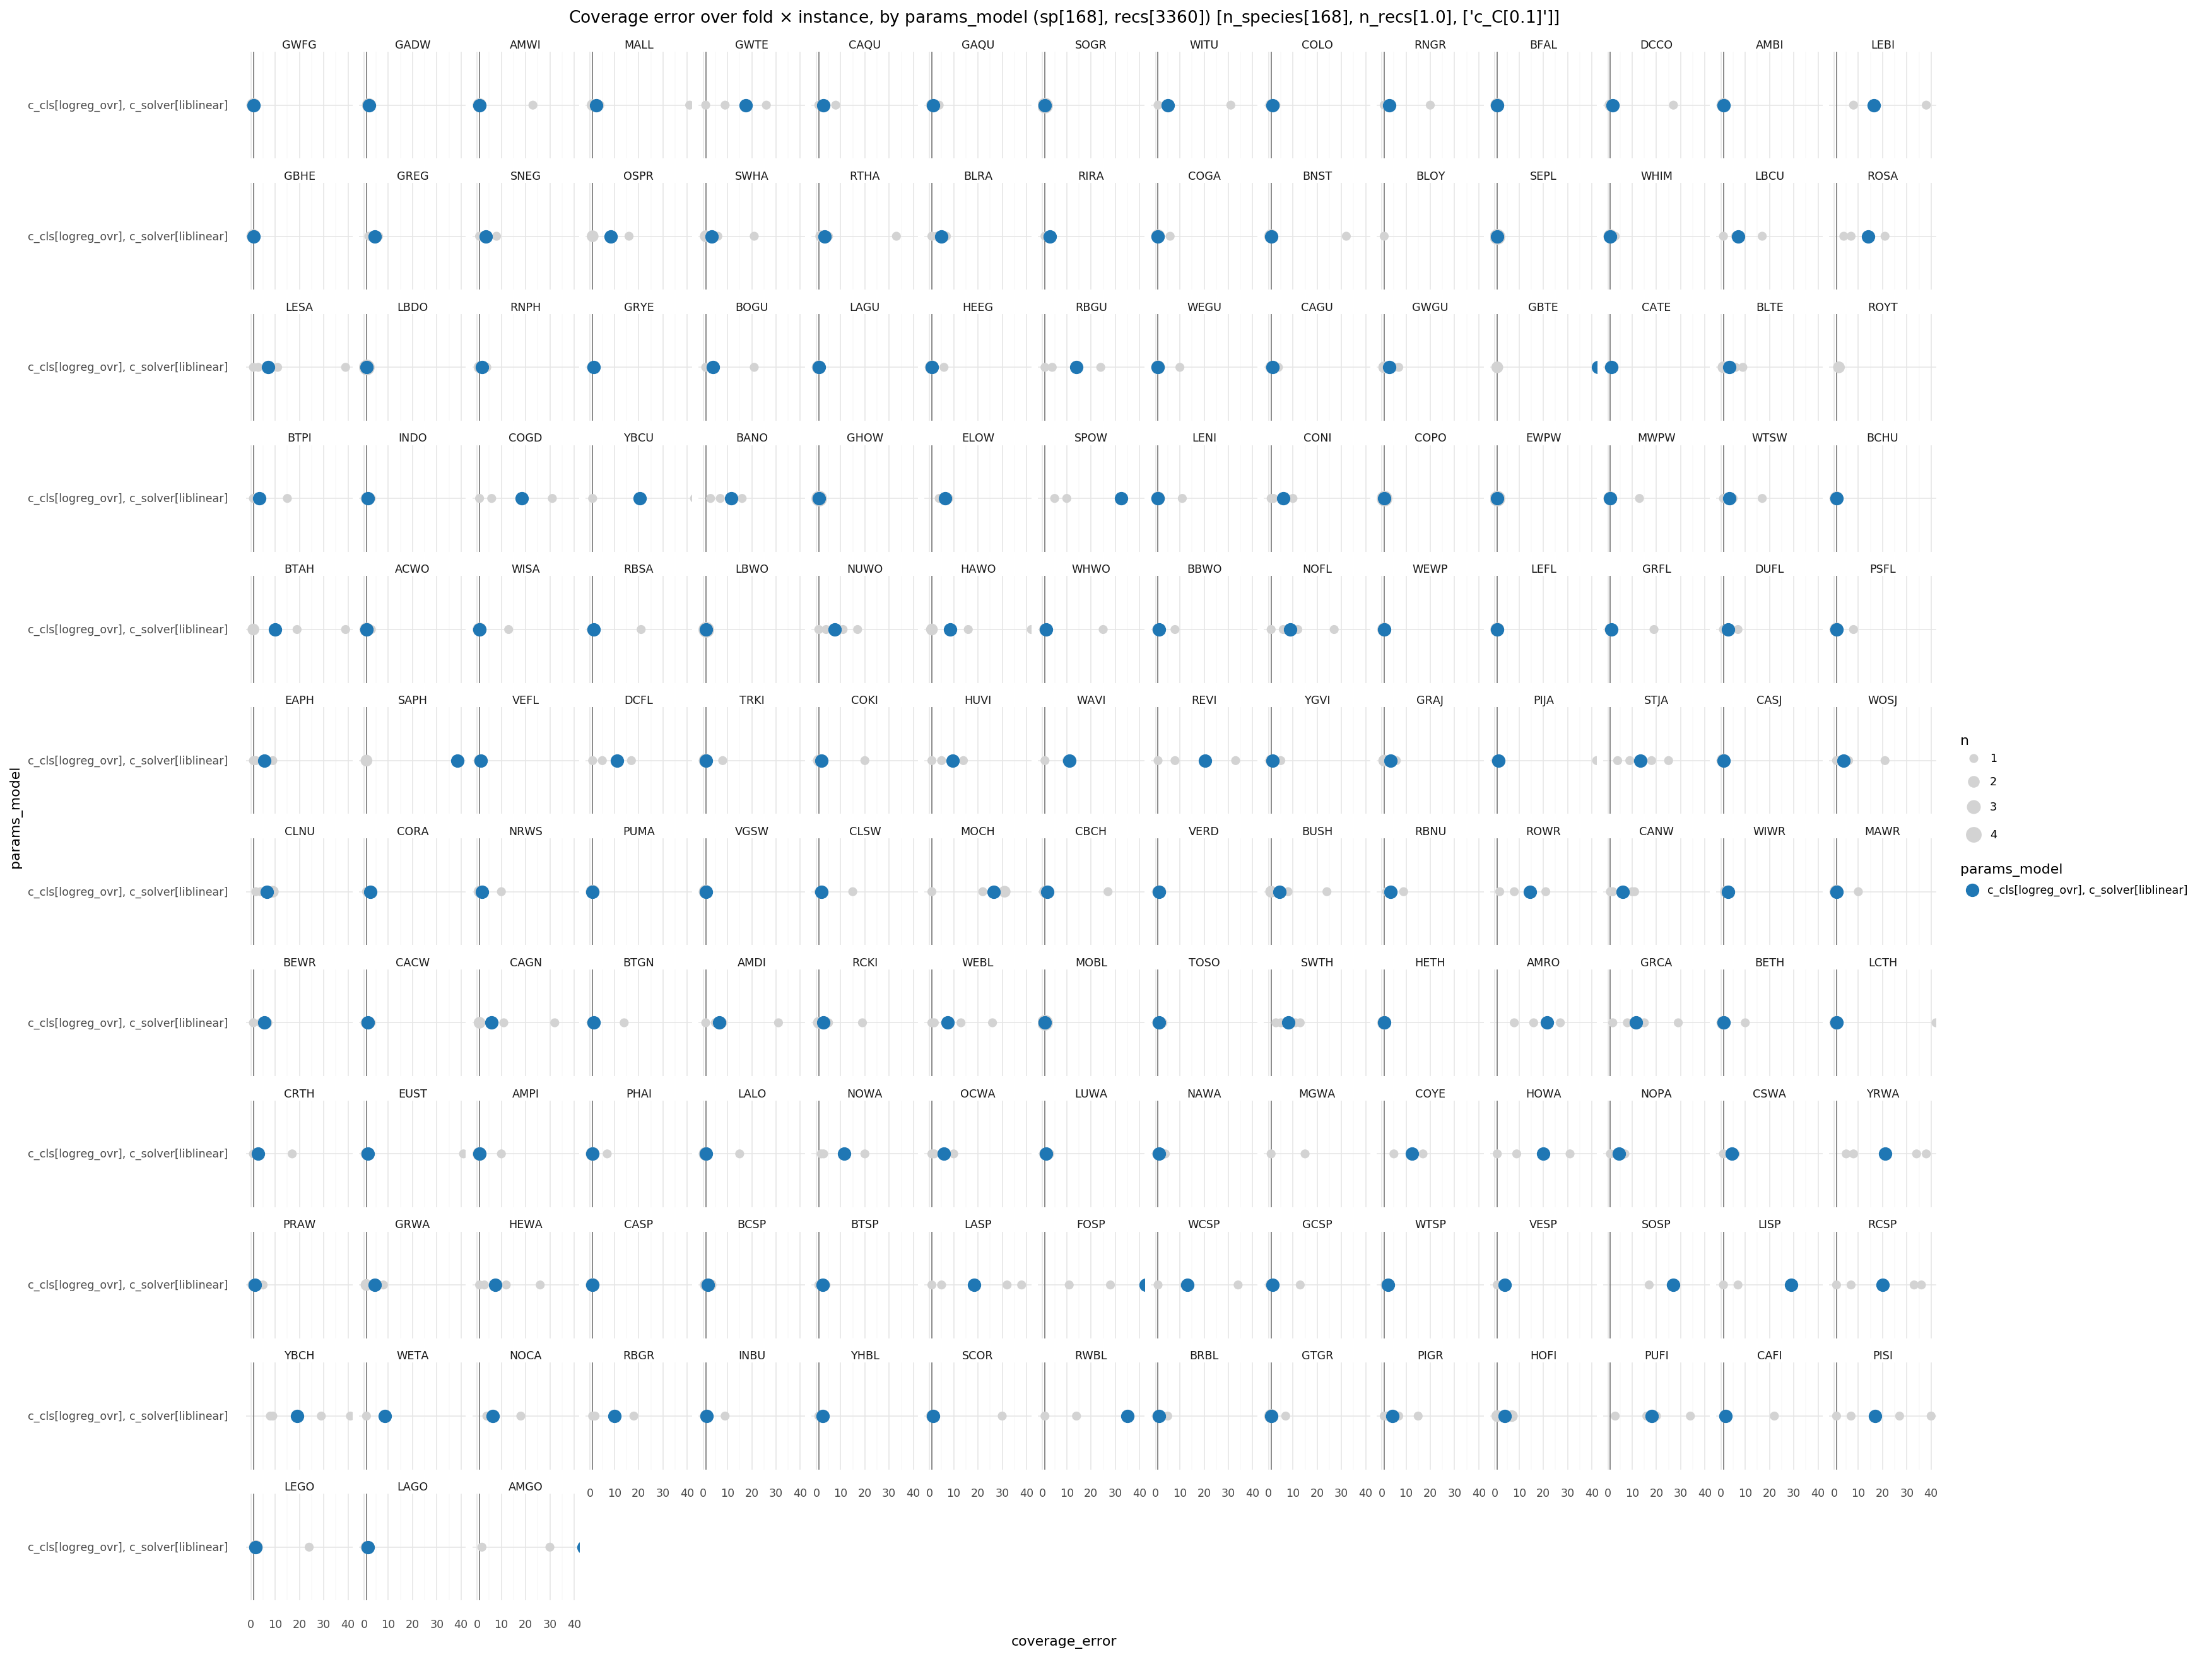

<ggplot: (329474024)>

In [ ]:
# TODO Slow, bad for notebook dev loop -- move lower, or disable by default?
# Facet by species
#   - Subset: all models
#   - Grain: sum(recs[model.test_i].groupby(params, y_true) for model)
#       - Over: fold, rec_id
#   - Dims: params, y_true
#   - Metrics: coverage_error.median
# in: coverage_errors_all_all, recs
[print(x) for x in coverage_errors_all_all.params_complexity.unique()];
params_complexity = [
    # 'c_max_depth[46]',
    # 'c_max_depth[1]',
    'c_C[0.1]',
    # 'c_class_weight[balanced]',
    # '',
]
(coverage_errors_all_all
    [lambda df: df.params_data == params_data]
    [lambda df: df.params_complexity.isin(params_complexity)]
    # [lambda df: df.params.astype(str).str.contains(r'c_n_estimators\[100\]')]  # XXX Subset models
    # .sample(200, random_state=0)  # Faster dev
    # [lambda df: df.y_true.isin(df.y_true.drop_duplicates().sample(n=3, random_state=0))]  # Faster dev
    .astype({'y_true': metadata.species.df.shorthand.dtype})
    # .pipe(df_reverse_cat, 'params_model')
    .pipe(ggplot)
    + aes(x='params_model', y='coverage_error')
    + aes(color='params_model')
    + facet_wrap('y_true',
        ncol=int((n_species * 1/(2/3)) ** .5),
    )
    + geom_hline(yintercept=1, color='grey')
    # + geom_hline(yintercept=recs.species.nunique(), color='grey')
    # Percentiles (faster, no overplot)
    # + geom_point(stat='summary', fun_y=np.median)
    # + geom_linerange(stat='summary', fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75))
    # Violin (slow, no overplot)
    # + geom_violin()
    # Boxplot (very slow, no overplot)
    # + geom_boxplot()
    # Points (medium cost, high overplot)
    #   - n (count) instead of prop (proportion)
    #   - scale_size_area() instead of default scale_size(), because it's a count [I don't grok this but it looks good]
    + geom_count(aes(size='..n..'), color='lightgray')
    + scale_size_area()
    # + geom_point(stat='summary', fun_y=np.median, shape='|', size=5, stroke=2)
    + geom_point(stat='summary', fun_y=np.median, size=5)
    + coord_flip(
        ylim=(0, 40),
    )
    + scale_color_cmap_d(mpl_cmap_repeat(1, 'tab20', 'tab20b', 'tab20c'))  # FIXME repeat(10) makes lots of blue/gray
    + guides(color=guide_legend(reverse=True))
    + theme(axis_text_y=element_text(size=6))
    + theme_minimal()  # [TODO Before other theme()]
    + theme_figsize(width=12*2, aspect_ratio=1/1)
    + ggtitle(rf'Coverage error over fold $\times$ instance, by params_model ({recs_stats}) [{params_data}, {params_complexity}]')
)

In [ ]:
ONE_MODEL_PLOTS_NEXT

NameError: name 'ONE_MODEL_PLOTS_NEXT' is not defined

# Model diagnostics: one model, all folds

In [ ]:
params_i = 3
params = cv_models.params.cat.categories[params_i]
print("params:\n%s" % '\n'.join('  %s: %r' % (i, x) for i, x in enumerate(cv_models.params.cat.categories)))
print()
print('models:')
print('  params[%s/%s]: %r' % (params_i, len(cv_models.params.cat.categories), params))
print('  fold[*/%s]' % cv.cv.n_splits)

params:
  0: 'n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.001]'
  1: 'n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01]'
  2: 'n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.05]'
  3: 'n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.1]'
  4: 'n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.5]'
  5: 'n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[1]'
  6: 'n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[10]'
  7: 'n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[100]'

models:
  params[3/8]: 'n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.1]'
  fold[*/1]


In [ ]:
# Coverage errors: one model, all folds
#   - Subset: models.params == params
#   - Grain: sum(recs[model.test_i] for model)
#   - Dims: model_id, params, fold, y_true, rec_id
#   - Metrics: coverage_error
coverage_errors_one_all = (coverage_errors_all_all
    [lambda df: df.params == params]  # One model, all folds
)
display(
    df_summary(coverage_errors_one_all).T,
    coverage_errors_one_all[:5],
)

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
model_id,category,89376,672,672,1,NaN,NaN,"n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.1], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.1], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.1], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.1], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.1], fold[0]"
params,category,83328,672,672,1,NaN,NaN,"n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.1]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.1]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.1]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.1]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.1]"
params_data,category,51072,672,672,1,NaN,NaN,"n_species[168], n_recs[1.0]","n_species[168], n_recs[1.0]","n_species[168], n_recs[1.0]","n_species[168], n_recs[1.0]","n_species[168], n_recs[1.0]"
params_model,category,163296,672,672,1,NaN,NaN,"c_cls[logreg_ovr], c_solver[liblinear]","c_cls[logreg_ovr], c_solver[liblinear]","c_cls[logreg_ovr], c_solver[liblinear]","c_cls[logreg_ovr], c_solver[liblinear]","c_cls[logreg_ovr], c_solver[liblinear]"
params_complexity,category,62496,672,672,1,NaN,NaN,c_C[0.1],c_C[0.1],c_C[0.1],c_C[0.1],c_C[0.1]
params_data_and_model,category,77280,672,672,1,NaN,NaN,"n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear]","n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear]","n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear]","n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear]","n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear]"
params_model_and_complexity,category,64512,672,672,1,NaN,NaN,"c_cls[logreg_ovr], c_solver[liblinear]\nc_C[0.1]","c_cls[logreg_ovr], c_solver[liblinear]\nc_C[0.1]","c_cls[logreg_ovr], c_solver[liblinear]\nc_C[0.1]","c_cls[logreg_ovr], c_solver[liblinear]\nc_C[0.1]","c_cls[logreg_ovr], c_solver[liblinear]\nc_C[0.1]"
fold,int64,16128,672,672,1,0.000,0.000,0,0,0,0,0
i,int64,18812,672,672,672,1679.338,970.784,0,837,1677,2517,3348


,model_id,params,params_data,params_model,params_complexity,params_data_and_model,params_model_and_complexity,fold,i,y_true,coverage_error
2016,"n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.1], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.1]","n_species[168], n_recs[1.0]","c_cls[logreg_ovr], c_solver[liblinear]",c_C[0.1],"n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear]","c_cls[logreg_ovr], c_solver[liblinear]\nc_C[0.1]",0,1765,CASJ,1.0
2017,"n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.1], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.1]","n_species[168], n_recs[1.0]","c_cls[logreg_ovr], c_solver[liblinear]",c_C[0.1],"n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear]","c_cls[logreg_ovr], c_solver[liblinear]\nc_C[0.1]",0,1551,VEFL,2.0
2018,"n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.1], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.1]","n_species[168], n_recs[1.0]","c_cls[logreg_ovr], c_solver[liblinear]",c_C[0.1],"n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear]","c_cls[logreg_ovr], c_solver[liblinear]\nc_C[0.1]",0,2967,LISP,7.0
2019,"n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.1], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.1]","n_species[168], n_recs[1.0]","c_cls[logreg_ovr], c_solver[liblinear]",c_C[0.1],"n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear]","c_cls[logreg_ovr], c_solver[liblinear]\nc_C[0.1]",0,578,LBCU,6.0
2020,"n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.1], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.1]","n_species[168], n_recs[1.0]","c_cls[logreg_ovr], c_solver[liblinear]",c_C[0.1],"n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear]","c_cls[logreg_ovr], c_solver[liblinear]\nc_C[0.1]",0,684,BOGU,21.0


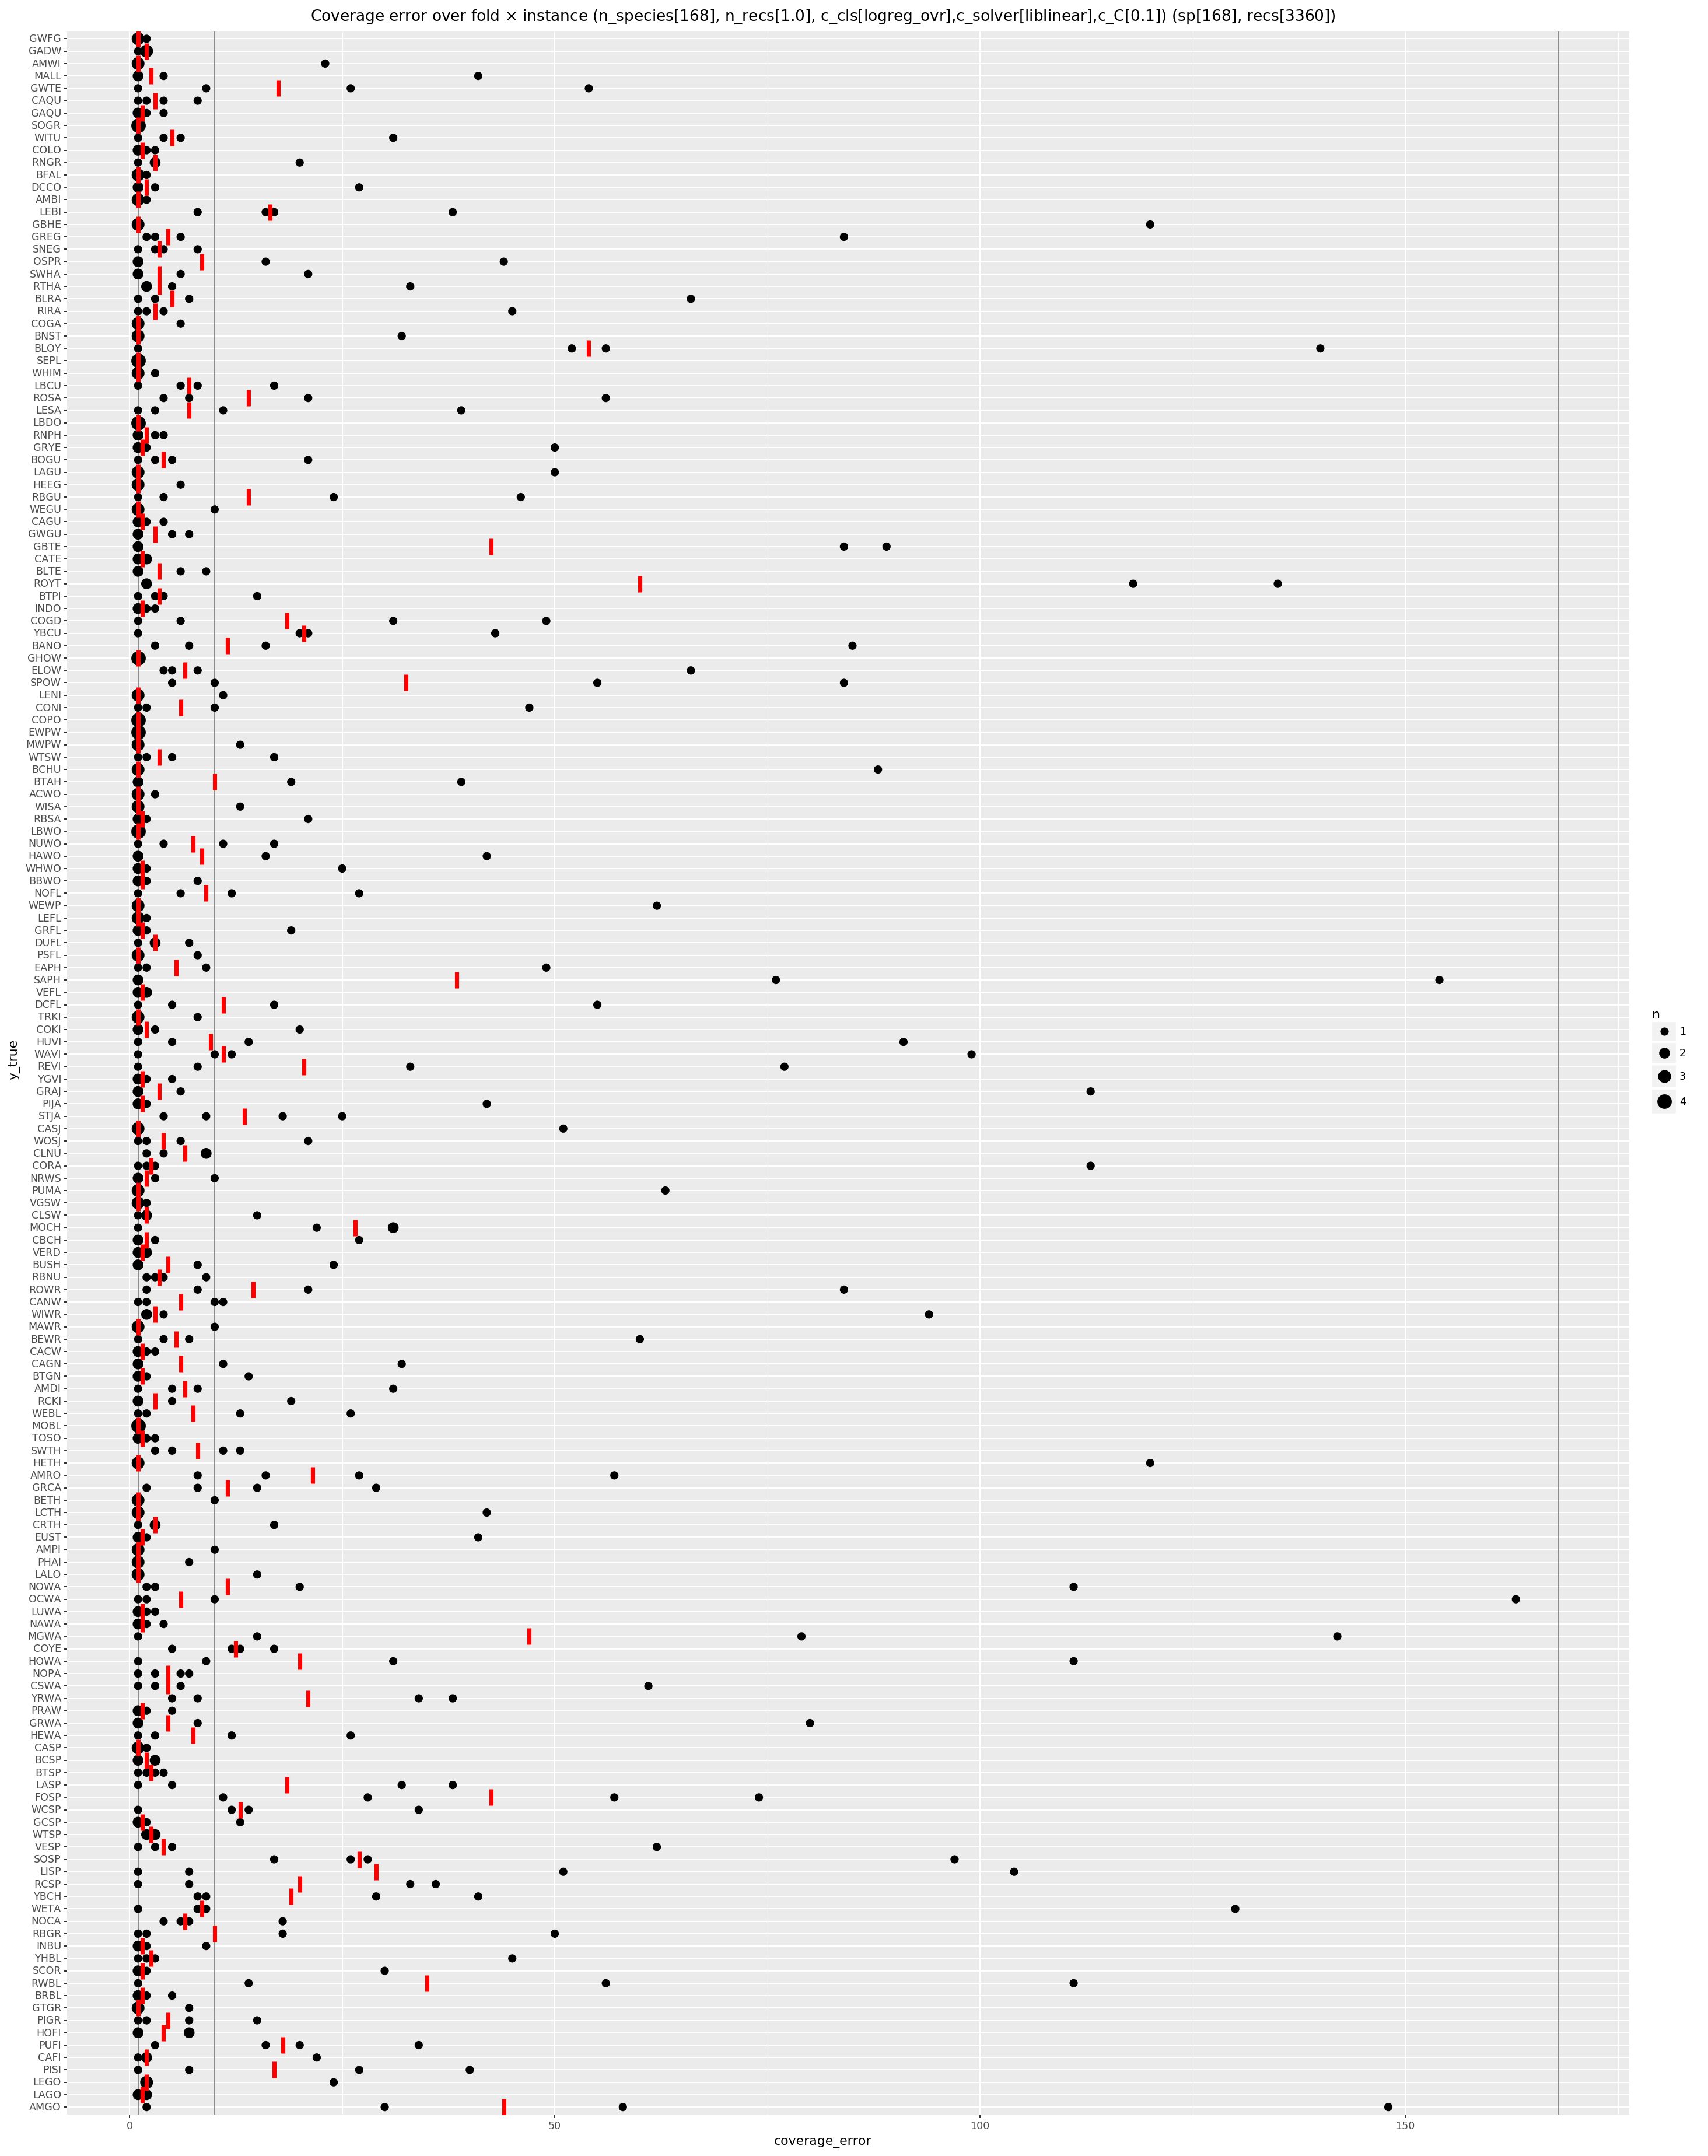

<ggplot: (322866026)>

In [ ]:
#   - Subset: models.params == params
#   - Grain: sum(recs[model.test_i].groupby(y_true) for model)
#       - Over: fold, rec_id
#   - Dims: y_true
#   - Metrics: count, coverage_error.percentiles
# in: coverage_errors_one_all, recs
(coverage_errors_one_all
    .astype({'y_true': metadata.species.df.shorthand.dtype})
    .pipe(df_reverse_cat, 'y_true')
    .pipe(ggplot, aes(x='y_true', y='coverage_error'))
    + geom_hline(yintercept=1, color='grey')
    + geom_hline(yintercept=10, color='grey')
    + geom_hline(yintercept=recs.species.nunique(), color='grey')
    + geom_count(aes(size='..n..'), alpha=1)  # n (count) instead of prop (proportion)
    + scale_size_area()  # Instead of default scale_size(), because it's a count [I don't grok this but it looks good]
    + geom_point(stat='summary', fun_y=np.median, alpha=1, color='red', shape='|', size=6, stroke=2)
    + coord_flip()
    # + theme_figsize('inline')
    # + theme_figsize('square')
    # + theme_figsize('half')
    + theme_figsize('half_dense')
    # + theme_figsize('full')
    # + theme_figsize('full_dense')
    + ggtitle(rf'Coverage error over fold $\times$ instance ({params}) ({recs_stats})')
)

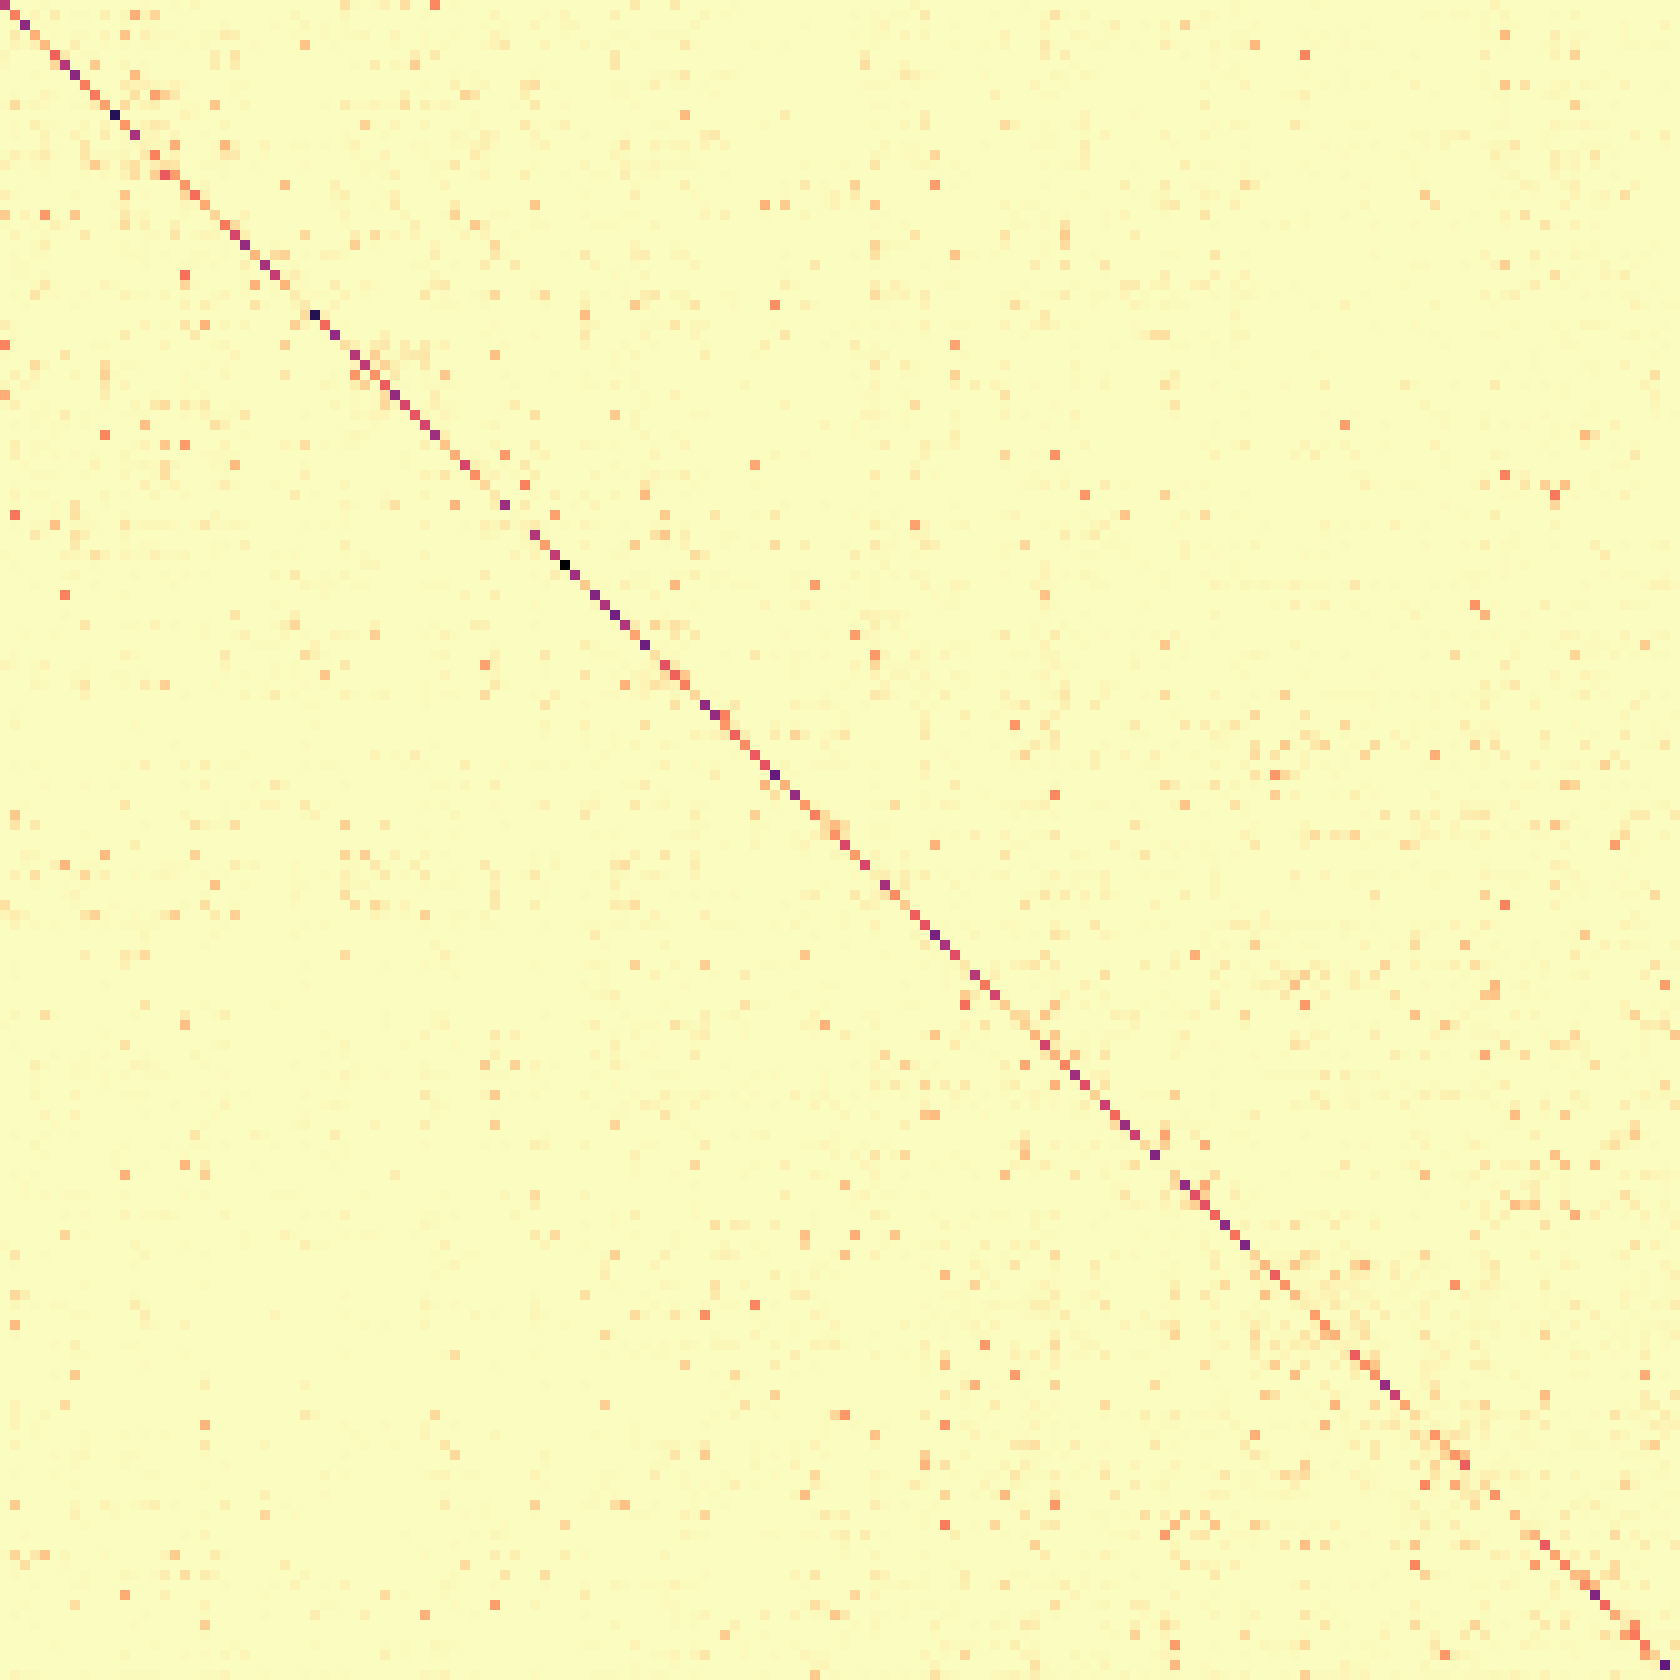

In [ ]:
# One-model/all-folds confusion matrix
with figsize(
    # 'square',
    # 'full',
    'full_dense',
):
    (cv_models
        [lambda df: df.params == params]
        .pipe(lambda df: plot_confusion_matrix(
            classes=df.iloc[0].test_evals.classes,
            M=np.array([
                row.test_evals.confusion_matrix_prob()
                for row in df_rows(df)
            ]).sum(axis=0),
            # normalize=False,  # For counts
            raw=True, scale=10,  # Faster dev
            format=None,  # Omit numbers, too dense
            title=f'({recs_stats})',
        ))
    )

# Model diagnostics: one model, one fold

In [ ]:
fold = 0
# params_i = ...  # Comment out to reuse from above
params = cv_models.params.cat.categories[params_i]
[(_, model)] = list(cv_models[lambda df: (df.params == params) & (df.fold == fold)].iterrows())
print("params:\n%s" % '\n'.join('  %s: %r' % (i, x) for i, x in enumerate(cv_models.params.cat.categories)))
print()
print('model:')
print('  params[%s/%s]: %r' % (params_i, len(cv_models.params.cat.categories), model.params))
print('  fold[%s/%s]' % (model.fold, cv.cv.n_splits))
print()
print(model)

[skip]

In [ ]:
# in: model
model_id = model.model_id
params = model.params
fold = model.fold
# train_evals = model.train_evals
test_evals = model.test_evals

# in: model, recs
# train_recs = recs.iloc[train_evals.i]
# train_X = Search.X(recs)[train_evals.i]
# train_y = Search.y(recs)[train_evals.i]
test_recs = recs.iloc[test_evals.i]
test_X = Search.X(recs)[test_evals.i]
test_y = Search.y(recs)[test_evals.i]  # (Don't need to store cv_models.test_evals.y if we have recs -- which sometimes we don't?)

display(
    # len(train_recs),
    len(test_recs),
)

[skip]

In [ ]:
# TODO Restore this plot like 'Coverage error over ...' above, so we can see _one_ model instead of aggregating over n_splits models
# # TODO Update [kill the .merge, then species -> y_true]
# (search.coverage_error_by(test_recs, 'id')
#     [:5]
#     # .merge(test_recs[['id', 'species']], on='id', how='left')
#     # .pipe(ggplot, aes(x='species', y='coverage_error'))
#     # + geom_count(aes(size='..n..'))
#     # + stat_summary(fun_y=np.median, geom='point', color='red', alpha=.5, shape='|', size=6, stroke=1)
#     # + stat_summary(
#     #     fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75),
#     #     geom='linerange', color='red', alpha=.5, size=1,
#     # )
#     # + coord_flip()
#     # + geom_hline(yintercept=len(search.classes_), color='grey')
#     # + scale_x_discrete(limits=list(reversed(test_recs.species.cat.categories)))
#     # + theme_figsize('square')
#     # + ggtitle(rf'Coverage error over instance ({model_id}) ({recs_stats})')
# )

[skip]

In [ ]:
# One-model/one-fold confusion matrix
with figsize(
    'square',
    # 'full',
    # 'full_dense',
):
    plot_confusion_matrix_df(
        confusion_matrix_prob_df(model.test_evals.y, model.test_evals.y_scores, model.test_evals.classes),
        title=model.model_id,
        # normalize=False,  # For counts
        raw=True, scale=10,  # Faster dev
        title=f'({recs_stats})',
    )

[skip]

In [ ]:
DEBUG_PLOTS_NEXT

# Debug plots, ignored by default

## Debug: resource usage

In [ ]:
(cv_models
    .pipe(df_reverse_cat, 'params', 'params_no_ns', 'ns')
    # Manually compute y.mean() per group
    .groupby('params').apply(lambda g: g.assign(mem_rss_delta_mean=lambda df: df.mem_rss_delta.mean()))
    .pipe(ggplot, aes(x='ns', group='params_no_ns'))
    + geom_col(aes(y='mem_rss_delta_mean', fill='params_no_ns'), position=position_dodge()) # Summary per fold
    + geom_point(aes(y='mem_rss_delta'), fill='none', size=2, position=position_dodge(width=.9)) # Distribution of folds
    + coord_flip()
    + scale_fill_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + scale_y_continuous(labels=labels_bytes(), breaks=breaks_bytes())
    + guides(fill=guide_legend(reverse=True))
    + theme(legend_position='bottom', legend_direction='vertical', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize(aspect_ratio=1/3*2)
    + ggtitle(f'Mem rss spread ($max-min$) ({recs_stats})')
)

In [ ]:
# TODO Very slow with ~200 models
cv_models_proc_stats = (cv_models
    # Enable these as needed (at the cost of mem usage)
    [[
        'model_id',
        'params',
        # 'params_dict',
        'params_data',
        'params_complexity',
        'params_model',
        'fold',
        # 'train_score',
        # 'test_score',
        # 'fit_time',
        # 'score_time',
        'mem_rss_delta',
        # 'mem_vms_delta',
        # 'train_evals',
        # 'test_evals',
        'proc_stats',
    ]]
    # TODO Faster way to do this? (.merge is >2x slower)
    .pipe(df_flatmap, lambda row: [
        row.append(pd.Series(dict(**stats)))
        for stats in row.proc_stats.stats
    ])
    # .pipe(lambda df: (df
    #     .merge(how='left',
    #         right=DF(
    #             OrderedDict(model_id=row.model_id, **stats)
    #             for row in df_rows(df)
    #             for stats in row.proc_stats.stats
    #         )
    #     )
    # ))
    # HACK Restore the cats that the df_flatmap just destroyed [copied from cv_results_splits_df]
    .pipe(df_ordered_cat,
        model_id=lambda df: df.model_id.unique(),
        params=lambda df: df.params.unique(),
    )
    .assign(
        cpu_user=lambda df: df.cpu_user.diff() * 100,
        cpu_system=lambda df: df.cpu_system.diff() * 100,
    )
    .pipe(tap, f=lambda df: display(
        df_summary(df).T,
        df[:5],
    ))
)

In [ ]:
# TODO Might need to stack/geom_area for overlapping runs
(cv_models_proc_stats
    .pipe(ggplot)
    + aes(x='time', color='model_id')
    + geom_line(aes(y='cpu_system'), linetype='dashed', size=.5)
    + geom_line(aes(y='cpu_system + cpu_user'), linetype='solid', size=.5)
    + expand_limits(y=0)
    + ylab('cpu')
    + scale_x_datetime(date_labels='%H:%M:%S')
    + scale_y_continuous(labels=lambda labels: ['%.3g%%' % x for x in labels])
    + theme(legend_position='bottom', legend_direction='vertical', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize('inline_short')
    + ggtitle('cpu over time (system + user)')
)

In [ ]:
(cv_models_proc_stats
    .pipe(ggplot)
    + aes(x='time', color='model_id')
    + geom_line(aes(y='mem_rss'), linetype='solid', size=.5)
    + geom_line(aes(y='mem_vms'), linetype='dashed', size=.5)
    + expand_limits(y=0)
    + ylab('mem')
    + scale_x_datetime(date_labels='%H:%M:%S')
    + scale_y_continuous(labels=labels_bytes(), breaks=breaks_bytes(pow=3))
    + theme(legend_position='bottom', legend_direction='vertical', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize('inline_short')
    + ggtitle('Mem over time (rss, vms)')
)

## Debug: RF tuning

In [ ]:
# TODO Revive if insightful
(cv_models
    .pipe(df_reverse_cat, 'params_no_ns')
    .assign(n_species=lambda df: df.params_dict.str['n_species'])
    .pipe(ggplot, aes(x='n_species', y='forest_depth_mean', color='params_no_ns'))
    # + facet_wrap('params_no_ns', ncol=2)
    + geom_point()
    + geom_pointrange(aes(ymin='forest_depth_mean - 2*forest_depth_std', ymax='forest_depth_mean + 2*forest_depth_std'))
    + geom_smooth(method='lm', se=False)  # Disable se because it only knows forest_depth_mean, no measure of spread
    + expand_limits(x=0)
    + scale_color_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + guides(color=guide_legend(reverse=True))
    + theme(legend_position='bottom', legend_direction='vertical', legend_box_spacing=.4, legend_key_height=8)
    # + theme_figsize(aspect_ratio=1/3)
    + theme_figsize(aspect_ratio=1/3)
    + ggtitle(f'RF depth vs. n_species ({recs_stats})')
)